# import các thư viện cần thiết

In [2]:
import os
import random
import time
import itertools
import numpy as np
import pandas as pd

from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity

import scipy.sparse as sp
from scipy.sparse import csr_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("PyTorch:", torch.__version__)

PyTorch: 2.6.0+cu124


In [3]:
import random, numpy as np, torch

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


In [4]:
import sys
import subprocess
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "fashion-clip"])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.0 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


CompletedProcess(args=['/usr/bin/python3', '-m', 'pip', 'install', '-q', 'fashion-clip'], returncode=0)

In [5]:
from fashion_clip.fashion_clip import FashionCLIP

fclip = FashionCLIP('fashion-clip')

2025-12-15 06:04:50.137113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765778690.455302      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765778690.546037      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [6]:
def build_text_column(outfits: pd.DataFrame, cfg):
    text_cols = cfg.get("outfit_text_cols", [])
    def _build(row):
        parts = []
        for c in text_cols:
            if c in row and pd.notna(row[c]):
                parts.append(str(row[c]))
        return " ".join(parts)
    return outfits.apply(_build, axis=1)

In [7]:
import os
import torch
import numpy as np

def save_cf_model(model_name, model, user_emb, item_emb, extra_info=None):
    """
    model_name: tên file, ví dụ 'ngcf', 'lightgcn', 'als'
    model: mô hình PyTorch (NGCF / LightGCN) hoặc None (cho ALS)
    user_emb, item_emb: torch.Tensor embedding
    extra_info: bất kỳ thông tin nào muốn lưu thêm (dict)
    """
    os.makedirs("saved_models", exist_ok=True)
    save_path = f"saved_models/{model_name}.pt"

    save_dict = {
        "user_emb": user_emb.cpu(),
        "item_emb": item_emb.cpu(),
        "extra": extra_info if extra_info is not None else {},
    }

    # Với NGCF / LightGCN thì có state_dict
    if model is not None:
        save_dict["model_state_dict"] = model.state_dict()

    torch.save(save_dict, save_path)
    print(f"[OK] Saved {model_name} → {save_path}")

In [8]:
def load_cf_model(model_name, ModelClass=None, device="cpu"):
    load_path = f"saved_models/{model_name}.pt"
    ckpt = torch.load(load_path, map_location=device)

    user_emb = ckpt["user_emb"].to(device)
    item_emb = ckpt["item_emb"].to(device)
    extra = ckpt["extra"]

    model = None
    if ModelClass is not None:
        # Detect model type automatically
        if ModelClass.__name__.lower() == "ngcf":
            model = ModelClass(
                extra["num_users"],
                extra["num_items"],
                dim=extra["dim"],
                layers=extra["layers"],
            ).to(device)

        elif ModelClass.__name__.lower() == "lightgcn":
            model = ModelClass(
                extra["num_users"],
                extra["num_items"],
                dim=extra["dim"],
                n_layers=extra["n_layers"],   # <--- dùng đúng tên tham số
            ).to(device)

        else:
            raise ValueError("ModelClass not supported.")

        model.load_state_dict(ckpt["model_state_dict"])
        model.eval()

    print(f"[OK] Loaded {model_name} from {load_path}")
    return model, user_emb, item_emb, extra


# Chuẩn bị dữ liệu vibrent-clothes-rental-dataset

In [9]:
# ========= CONFIG DATASET =========
# Chỉ cần sửa block này khi đổi dataset

DATASET_NAME = "vibrent"  # tên để đặt file output embeddings, log,...


# local:
# BASE_PATH = r"D:\DACNTT"
# IMAGE_DIR = os.path.join(BASE_PATH, "images")

# Kaggle:
BASE_PATH = "/kaggle/input/vibrent-clothes-rental-dataset"
IMAGE_DIR = os.path.join(BASE_PATH, "images")
# File & cột tương ứng với dataset Vibrent
CFG = {
    "outfits_file": "outfits.csv",
    "pictures_file": "picture_triplets.csv",
    "user_activity_file": "user_activity_triplets.csv",
    "csv_sep": ";",
    # cột user / item / thời gian trong user_activity
    "user_col": "customer.id",
    "item_col": "outfit.id",
    "start_time_col": "rentalPeriod.start",
    "end_time_col": "rentalPeriod.end",
    # cột trong pictures
    "picture_outfit_col": "outfit.id",
    "picture_filename_col": "file_name",
    "picture_displayorder_col": "displayOrder",
    # cột để xây text cho FashionCLIP
    # sẽ join các cột này bằng khoảng trắng (bỏ NA)
    "outfit_text_cols": ["description", "outfit_tags"],
}

print("BASE_PATH:", BASE_PATH)
print("IMAGE_DIR:", IMAGE_DIR)
print("CFG:", CFG)


BASE_PATH: /kaggle/input/vibrent-clothes-rental-dataset
IMAGE_DIR: /kaggle/input/vibrent-clothes-rental-dataset/images
CFG: {'outfits_file': 'outfits.csv', 'pictures_file': 'picture_triplets.csv', 'user_activity_file': 'user_activity_triplets.csv', 'csv_sep': ';', 'user_col': 'customer.id', 'item_col': 'outfit.id', 'start_time_col': 'rentalPeriod.start', 'end_time_col': 'rentalPeriod.end', 'picture_outfit_col': 'outfit.id', 'picture_filename_col': 'file_name', 'picture_displayorder_col': 'displayOrder', 'outfit_text_cols': ['description', 'outfit_tags']}


In [10]:
def load_dataset(base_path, cfg):
    sep = cfg.get("csv_sep", ",")

    outfits = pd.read_csv(
        os.path.join(base_path, cfg["outfits_file"]),
        sep=sep,
        quotechar='"',
        engine="python",
        on_bad_lines="skip"
    )

    pictures = pd.read_csv(
        os.path.join(base_path, cfg["pictures_file"]),
        sep=sep,
        quotechar='"',
        engine="python"
    )

    user_activity = pd.read_csv(
        os.path.join(base_path, cfg["user_activity_file"]),
        sep=sep,
        quotechar='"',
        engine="python"
    )

    print("Outfits:", outfits.shape)
    print("Pictures:", pictures.shape)
    print("User activity:", user_activity.shape)
    return outfits, pictures, user_activity


outfits, pictures, user_activity = load_dataset(BASE_PATH, CFG)

Outfits: (15649, 11)
Pictures: (50193, 4)
User activity: (64419, 4)


In [11]:
image_dir = "/kaggle/input/vibrent-clothes-rental-dataset/images"

def load_image(file_name):
    path = os.path.join(image_dir, file_name)
    if os.path.exists(path):
        try:
            return Image.open(path)
        except:
            return None
    return None


In [12]:
main_pictures = (
    pictures.sort_values("displayOrder")
    .groupby("outfit.id")
    .first() 
    .reset_index()
)

main_pictures["image_obj"] = main_pictures["file_name"].apply(load_image)
main_pictures = main_pictures[main_pictures["image_obj"].notnull()]
print("Số outfit có main picture (theo CSV):", len(main_pictures))
print(main_pictures.head())

Số outfit có main picture (theo CSV): 15157
                                 outfit.id  \
0  outfit.00004b4d01ca4ab0a70cf073ba74fefa   
1  outfit.0013691ff35b440e9dcfe1748ec184c7   
2  outfit.0014a5c89b244077a3d7cffd4549718e   
3  outfit.0018701ce6b049ebadc314d16623caa8   
4  outfit.001bf665330140cf854dcfb1cbff6b5f   

                                 picture.id  displayOrder  \
0  picture.a2b794c7ef83495a8997e7b0c318d65a             1   
1  picture.9c821ecbecb14c959f35078010fb91f3             1   
2  picture.b9aa39eb40f5410fa4fe101236241b19             1   
3  picture.b944a50f20fd4c7f954213dc7c38a776             1   
4  picture.94112f6c60994f3f9bcae4e967e5f55f             0   

                              file_name  \
0  a2b794c7ef83495a8997e7b0c318d65a.jpg   
1  9c821ecbecb14c959f35078010fb91f3.jpg   
2  b9aa39eb40f5410fa4fe101236241b19.jpg   
3  b944a50f20fd4c7f954213dc7c38a776.jpg   
4  94112f6c60994f3f9bcae4e967e5f55f.jpg   

                                           image_obj 

# Tạo outfitsEmbedding hoặc load lên nếu đã có

In [13]:
import os
import pickle
import numpy as np
import pandas as pd

EMB_FILE_NAME = "outfit_embeddings.pkl"
OUTFIT_EMB_PATH = os.path.join("/kaggle/working/", EMB_FILE_NAME)

outfit_embeddings = None


def build_text_column(outfits: pd.DataFrame, cfg):
    text_cols = cfg.get("outfit_text_cols", [])
    def _build(row):
        parts = []
        for c in text_cols:
            if c in row and pd.notna(row[c]):
                parts.append(str(row[c]))
        return " ".join(parts)
    return outfits.apply(_build, axis=1)


# ============================================================
# 1) LOAD EMBEDDING NẾU ĐÃ CÓ
# ============================================================
if os.path.exists(OUTFIT_EMB_PATH):
    print("=> Đang load outfit_embeddings từ", OUTFIT_EMB_PATH)

    with open(OUTFIT_EMB_PATH, "rb") as f:
        outfit_embeddings = pickle.load(f)

    print("  - Loaded dict, số outfit:", len(outfit_embeddings))

else:
    # ============================================================
    # 2) TÍNH TEXT + IMAGE EMBEDDING
    # ============================================================
    print("=> Không thấy embedding → bắt đầu tính TEXT + IMAGE bằng FashionCLIP")

    # ===== TEXT EMBEDDINGS =====
    print("[1/2] Encoding TEXT ...")
    outfits["text"] = build_text_column(outfits, CFG)
    text_embeddings = fclip.encode_text(outfits["text"].tolist(), batch_size=32)

    # ===== IMAGE EMBEDDINGS =====
    print("[2/2] Encoding IMAGES ...")
    images = main_pictures["image_obj"].tolist()
    image_embeddings = fclip.encode_images(images, batch_size=32)
    print("Ảnh encode được:", len(image_embeddings))

    # ===== GỘP TEXT + IMAGE =====
    text_emb_map = dict(zip(outfits["id"], text_embeddings))
    image_emb_map = dict(zip(main_pictures["outfit.id"], image_embeddings))

    outfit_embeddings = {}

    for oid in outfits["id"]:
        if oid in text_emb_map and oid in image_emb_map:
            t = text_emb_map[oid]
            i = image_emb_map[oid]

            # Chuẩn hóa trước khi cộng
            t = t / np.linalg.norm(t)
            i = i / np.linalg.norm(i)

            outfit_embeddings[oid] = 0.5 * t + 0.5 * i

    # ===== SAVE =====
    print("=> Saving:", OUTFIT_EMB_PATH)
    with open(OUTFIT_EMB_PATH, "wb") as f:
        pickle.dump(outfit_embeddings, f)

# ============================================================
# 3) THÔNG TIN EMBEDDING
# ============================================================
print("Done. Outfit embeddings =", len(outfit_embeddings))
feat_dim = next(iter(outfit_embeddings.values())).shape[0]
print("Embedding dimension =", feat_dim)


=> Đang load outfit_embeddings từ /kaggle/working/outfit_embeddings.pkl
  - Loaded dict, số outfit: 15157
Done. Outfit embeddings = 15157
Embedding dimension = 512


# Hàm lấy outfits từ text 

In [14]:
import numpy as np

def find_outfits_from_text(query_text, outfit_embeddings, model, topk=10):
    """
    Tìm top-K outfit phù hợp với text (query) dựa trên FashionCLIP embedding.
    """
    # 1) Encode text thành embedding
    text_emb = model.encode_text([query_text], batch_size=1)[0]
    text_emb = text_emb.astype(np.float32)

    # L2 normalize để cosine similarity
    text_emb = text_emb / (np.linalg.norm(text_emb) + 1e-8)

    # 2) Chuẩn bị item embedding matrix
    outfit_ids = list(outfit_embeddings.keys())
    item_matrix = np.vstack([outfit_embeddings[oid] for oid in outfit_ids]).astype(np.float32)

    # Normalize item embeddings
    item_matrix = item_matrix / (np.linalg.norm(item_matrix, axis=1, keepdims=True) + 1e-8)

    # 3) Tính cosine similarity
    scores = item_matrix @ text_emb     # shape = [num_items]

    # 4) Lấy top-k
    top_idx = np.argsort(-scores)[:topk]

    results = [(outfit_ids[i], float(scores[i])) for i in top_idx]
    return results
def get_images_for_query(query_text, topk=5):
    results = find_outfits_from_text(query_text, outfit_embeddings, fclip, topk=topk)

    pics = []
    for oid, score in results:
        row = main_pictures[main_pictures["outfit.id"] == oid]
        if len(row) > 0:
            file = row.iloc[0]["file_name"]
            img = load_image(file)
            pics.append((img, oid, score))
    return pics


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00,  6.10it/s]


Outfit: outfit.8e8df8e62f5e8701 | score=0.737


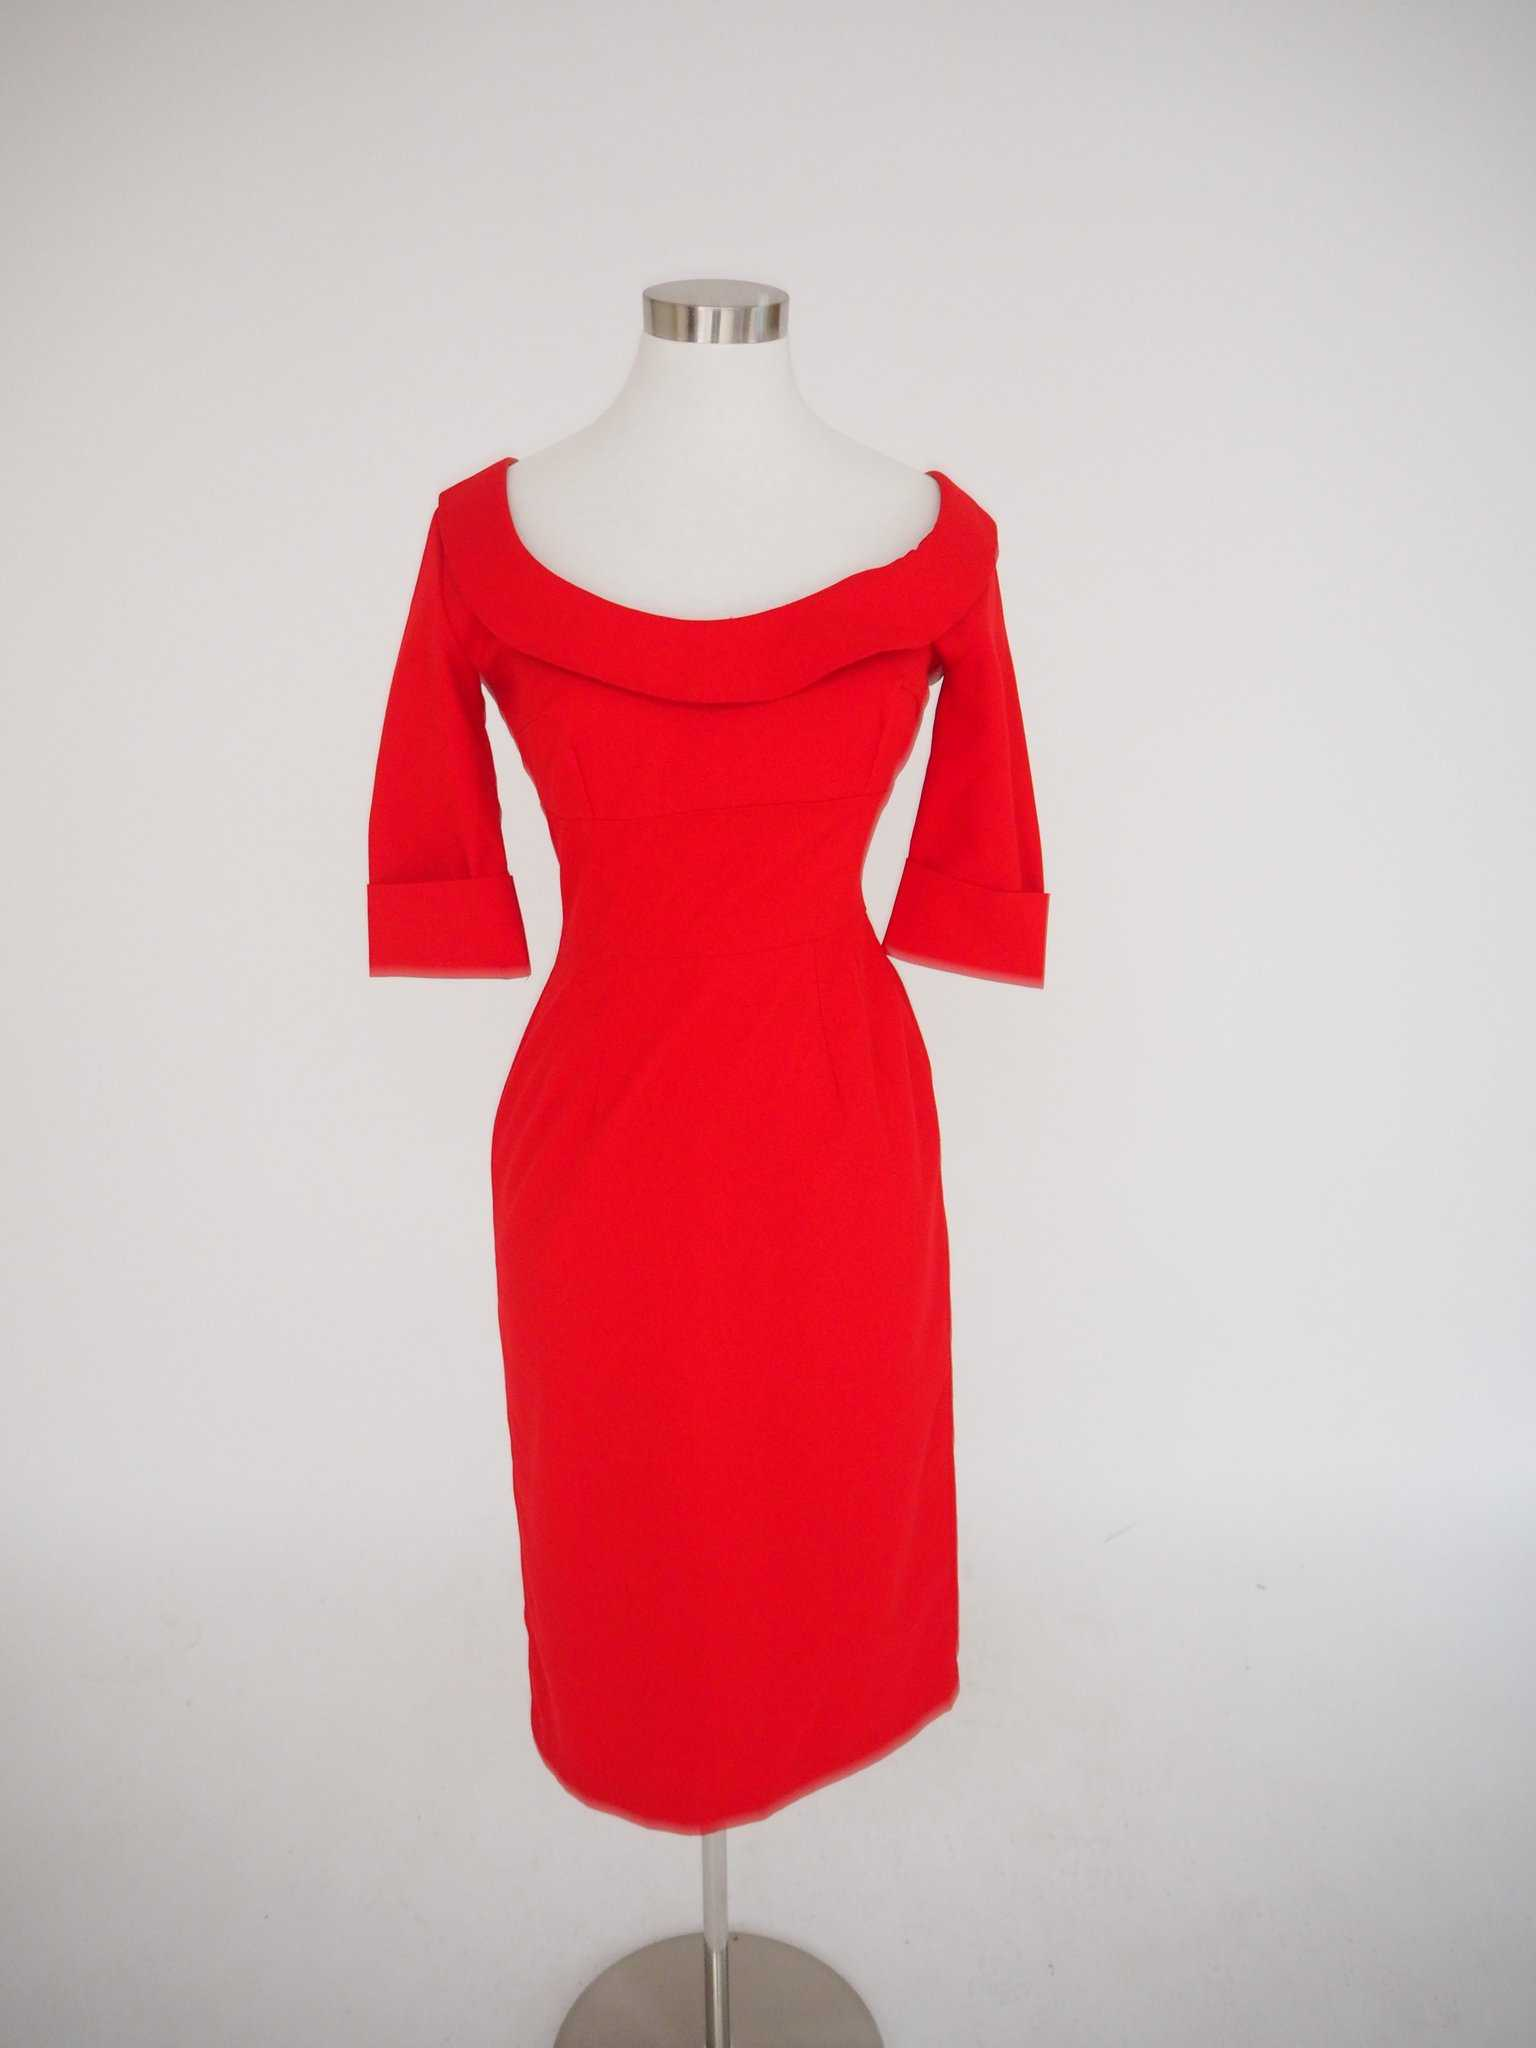

Outfit: outfit.976c48c39edf6d50 | score=0.736


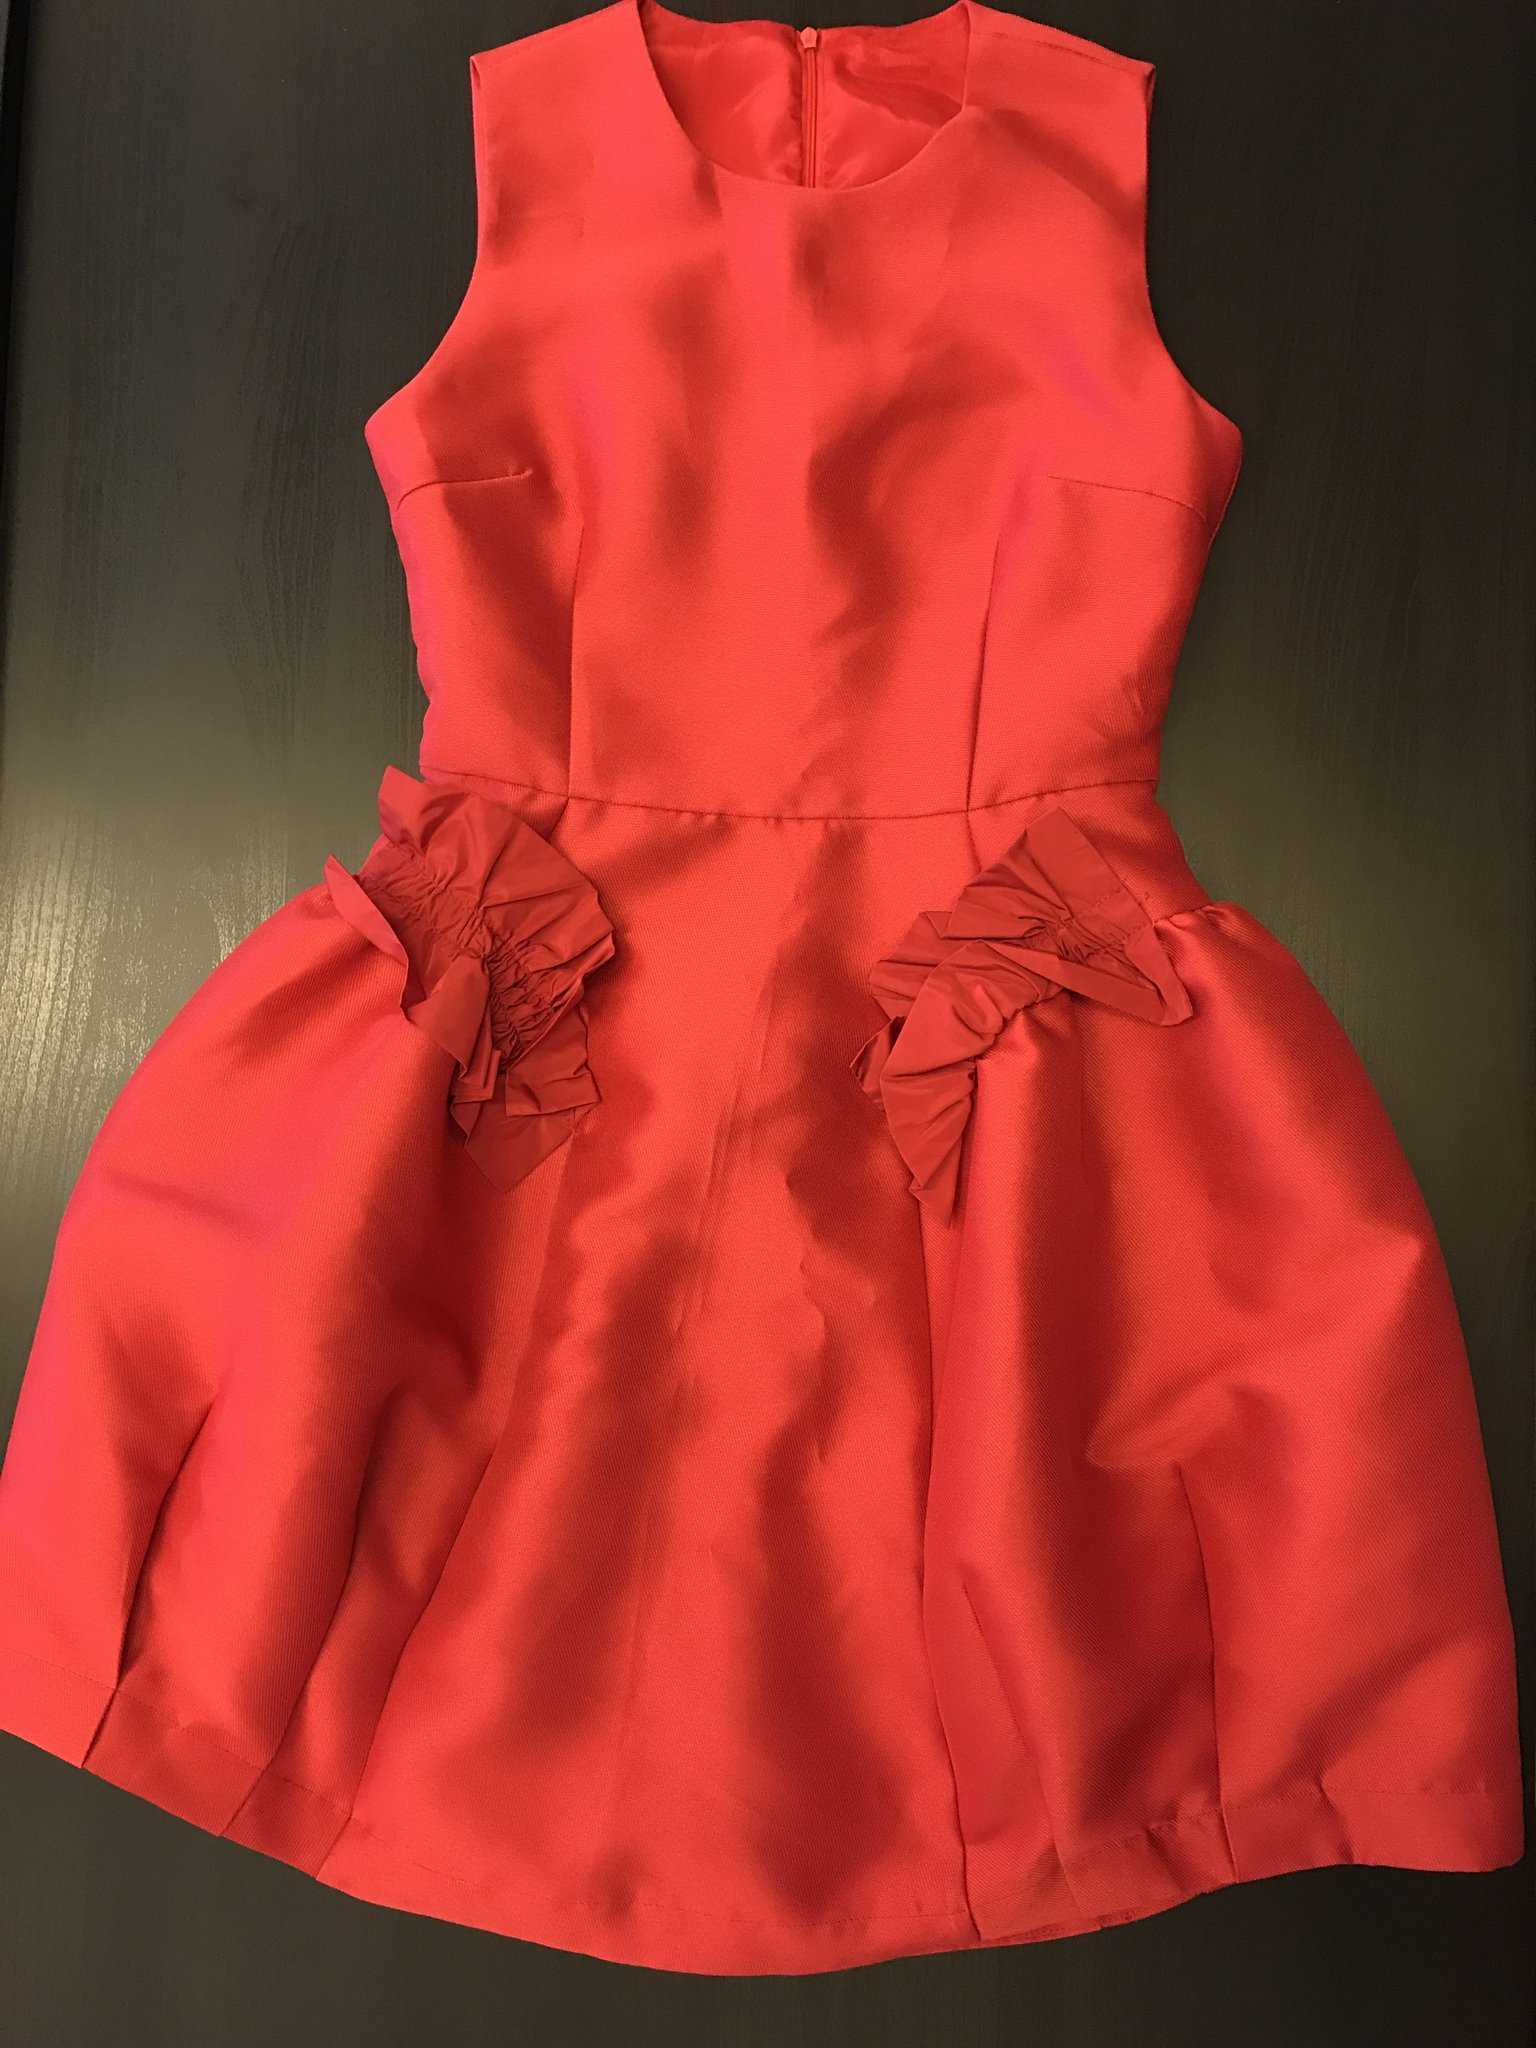

Outfit: outfit.a6a74219b7a9c5a1 | score=0.721


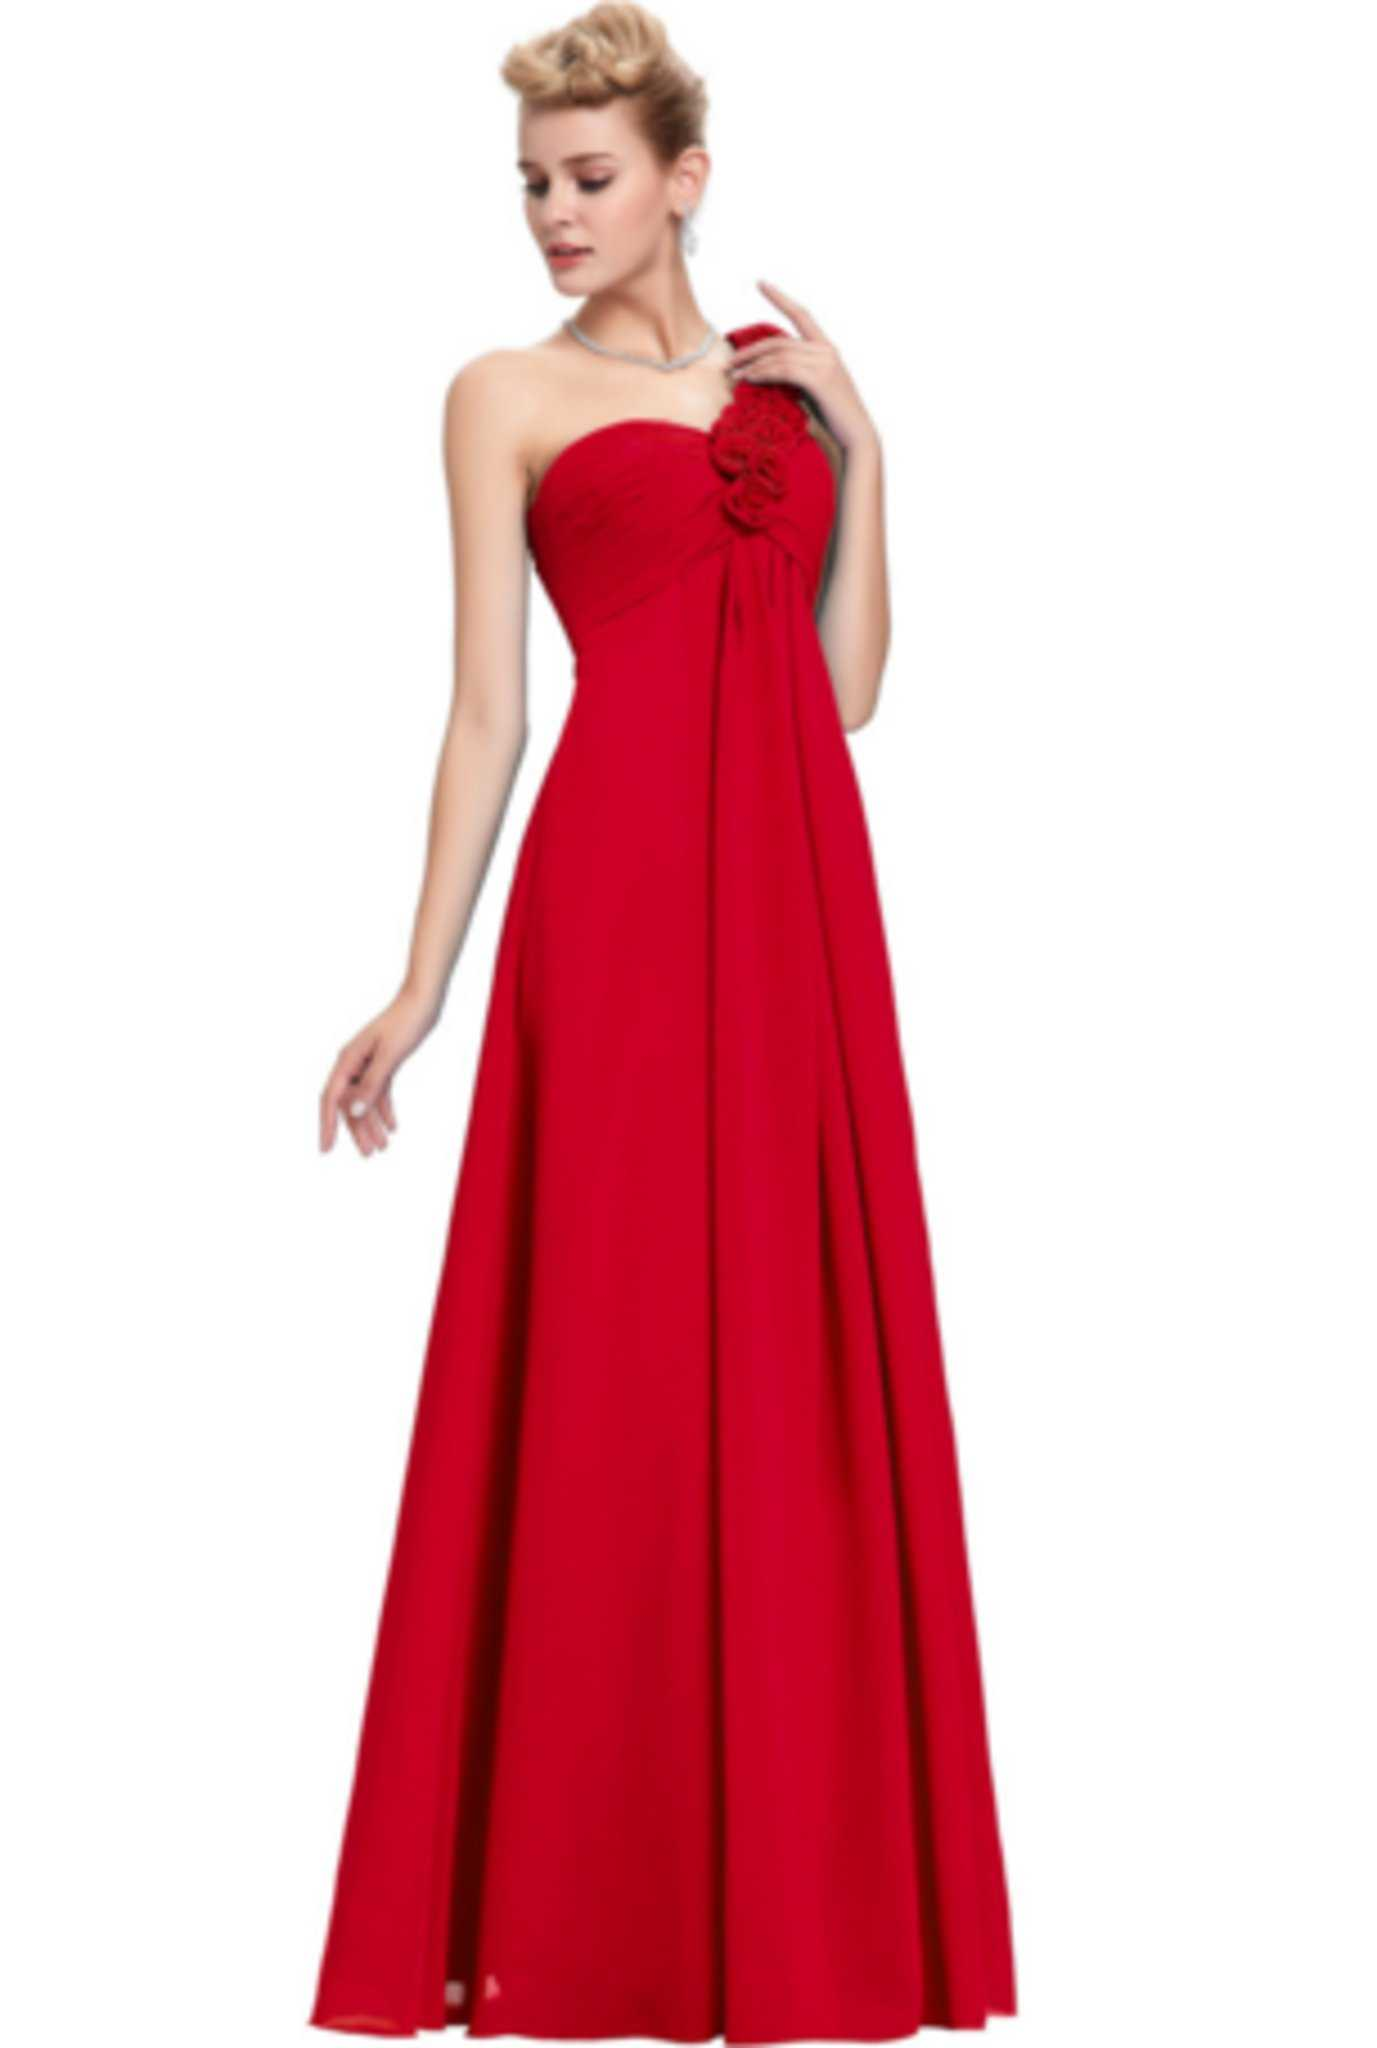

Outfit: outfit.a15ff8a939598687 | score=0.720


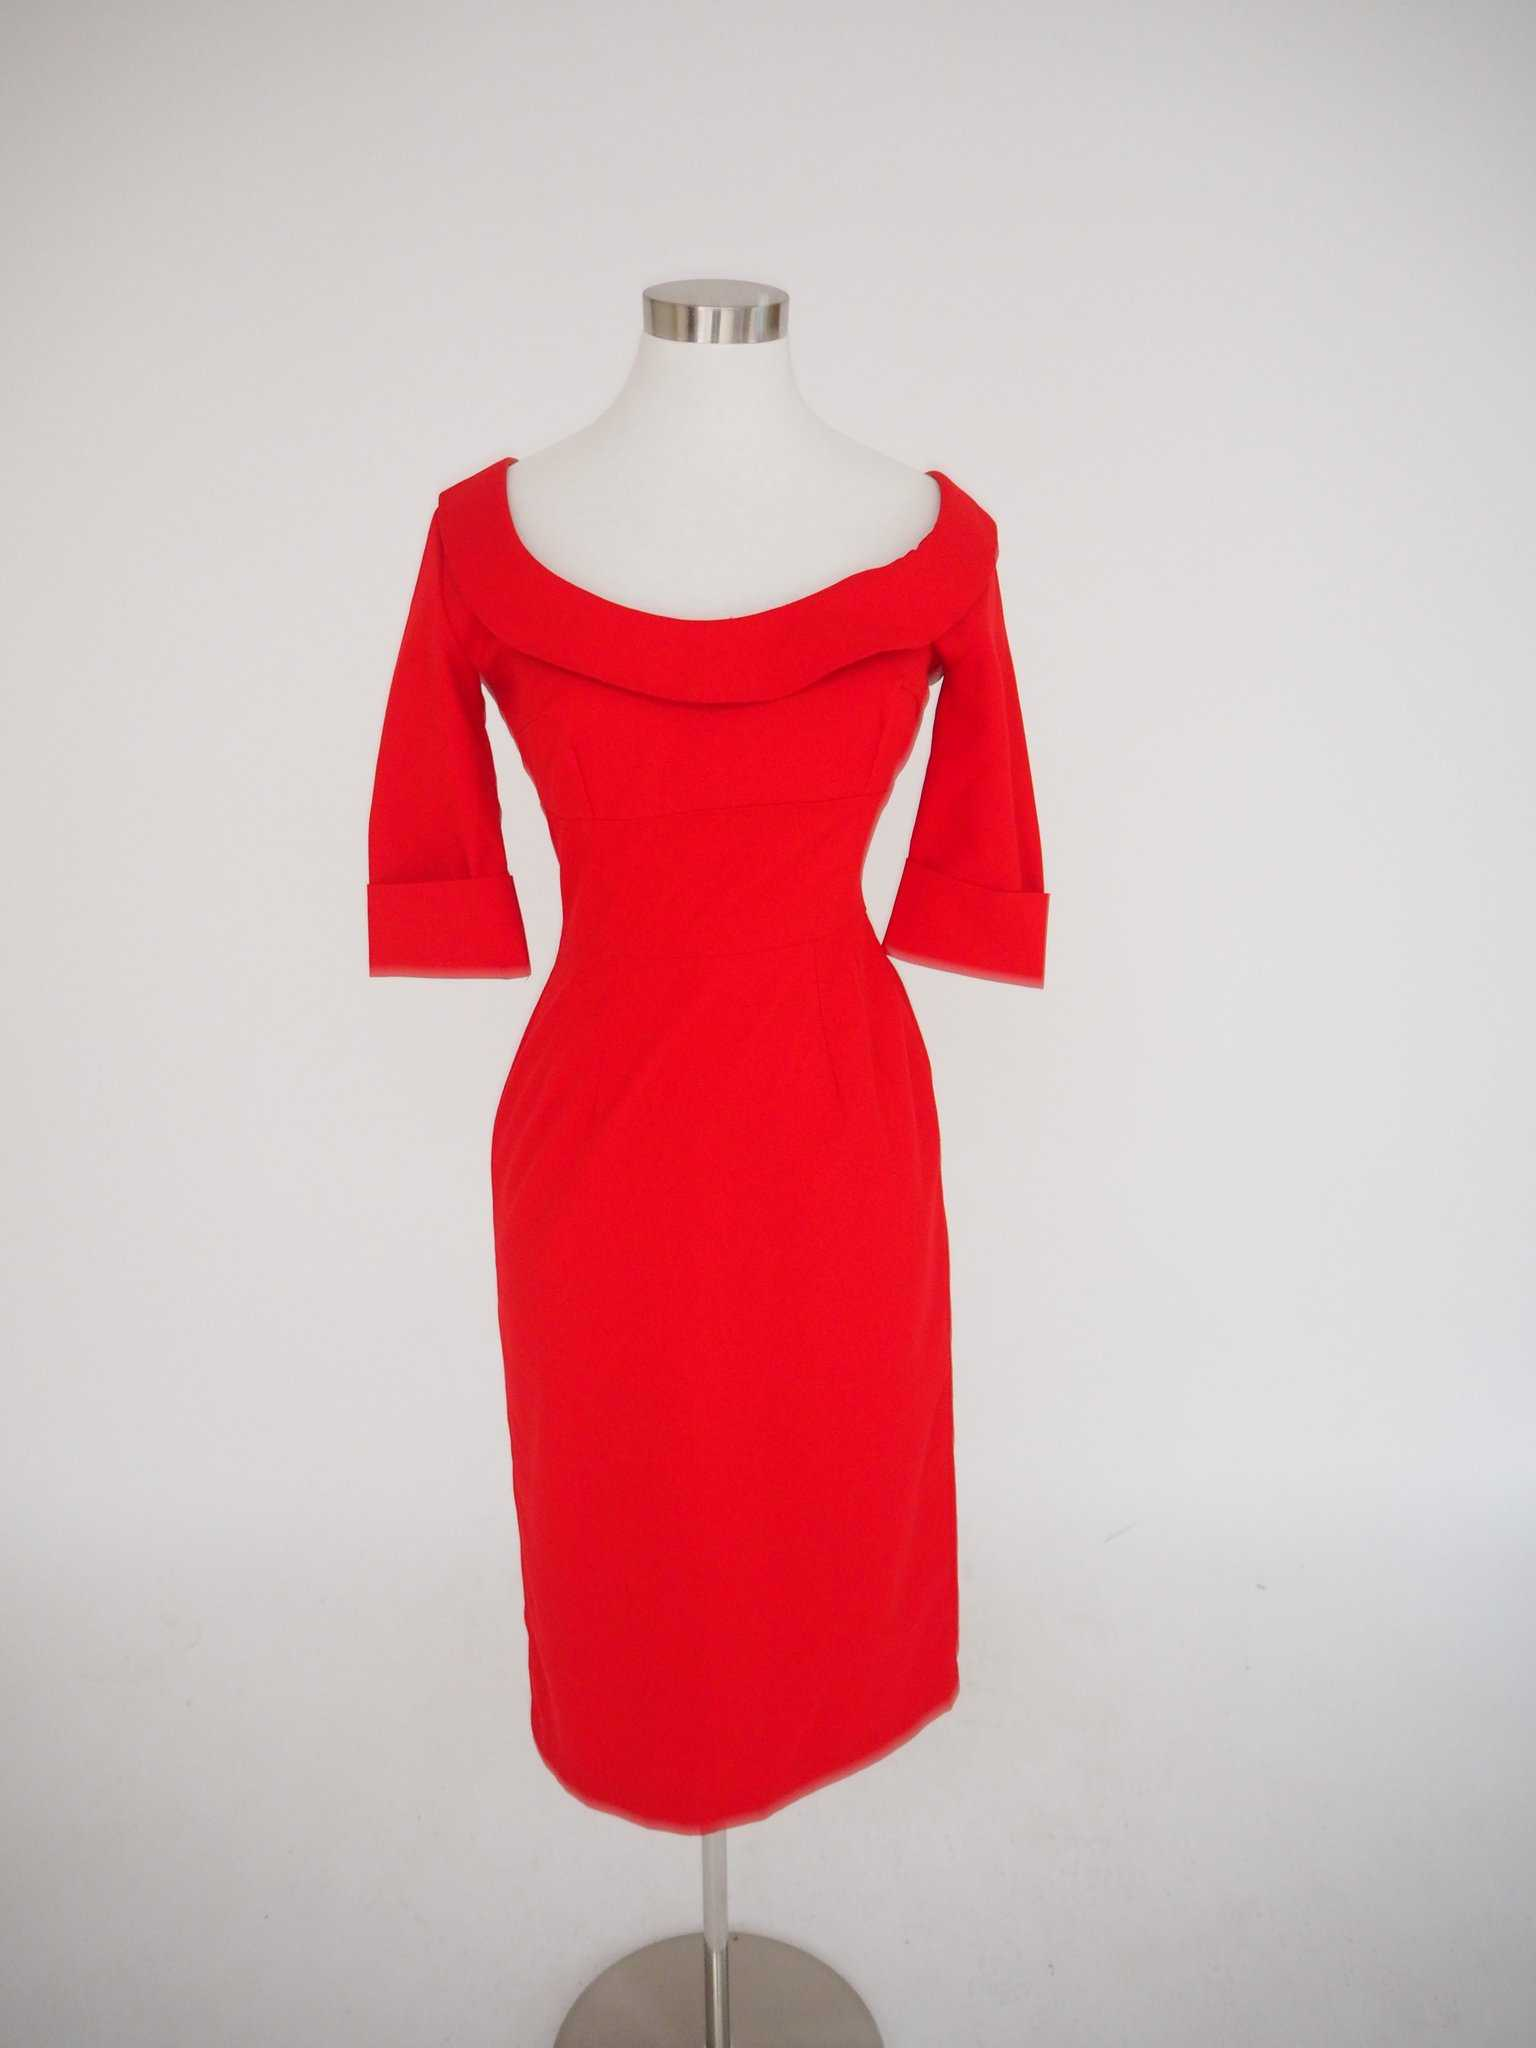

Outfit: outfit.8e9a63c6e19d665e | score=0.706


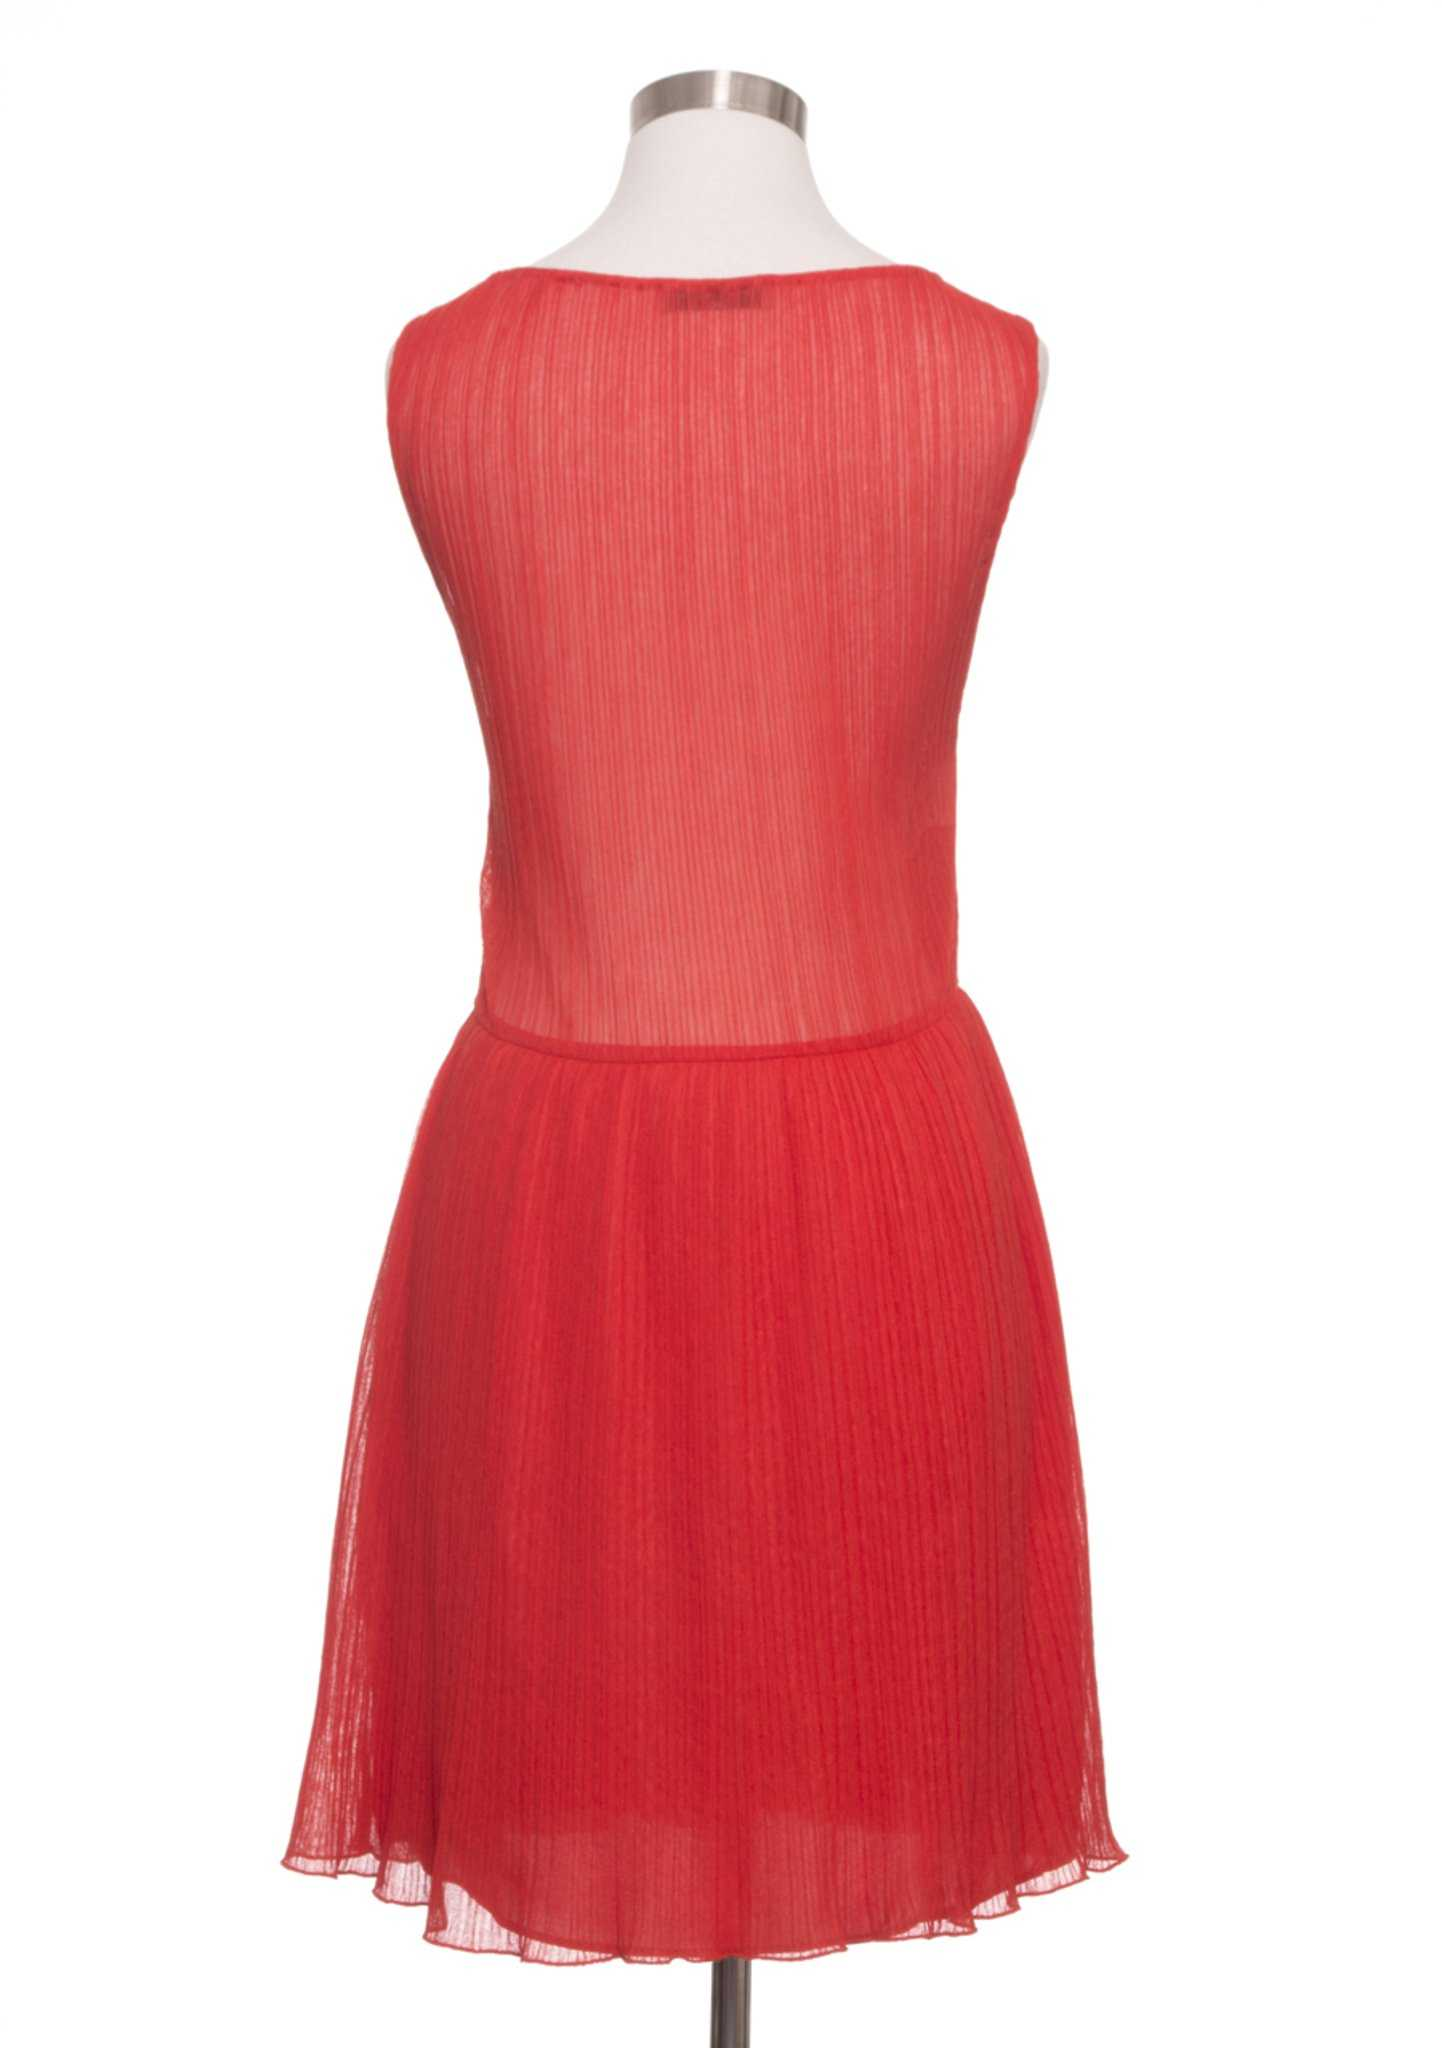

In [15]:
from IPython.display import display

query = "red dress"
pics = get_images_for_query(query, topk=5)

for img, oid, score in pics:
    print(f"Outfit: {oid} | score={score:.3f}")
    display(img)


# CFRS 

In [16]:
#vibrent
#CF preprocessing – encode user/item, split train/test, build A_train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

u_col = CFG["user_col"]
i_col = CFG["item_col"]
t_start = CFG["start_time_col"]
t_end = CFG["end_time_col"]

# 1) Parse thời gian & sort
for col in [t_start, t_end]:
    user_activity[col] = pd.to_datetime(user_activity[col], errors="coerce", utc=True)
user_activity = user_activity.dropna(subset=[t_start, t_end])
user_activity = user_activity.sort_values([u_col, t_start, t_end])
print("[OK] Parse & sort thời gian.")

# 2) Encode user / item
user_enc = LabelEncoder().fit(user_activity[u_col].astype(str))
item_enc = LabelEncoder().fit(user_activity[i_col].astype(str))

user_activity["user_id"] = user_enc.transform(user_activity[u_col].astype(str))
user_activity["item_id"] = item_enc.transform(user_activity[i_col].astype(str))

num_users = user_activity["user_id"].nunique()
num_items = user_activity["item_id"].nunique()

# mapping giữa item_id (index trong matrix) và outfit-id gốc
oid_from_item = dict(zip(user_activity["item_id"], user_activity[i_col]))
item_from_oid = {v: k for k, v in oid_from_item.items()}

print(f"[COUNTS] users={num_users} | items={num_items} | interactions={len(user_activity)}")

# 3) Chia train/test theo thời gian cho từng user
TEST_RATIO = 0.2
user_train_items, user_test_items = {}, {}

for u, g in user_activity.groupby("user_id", sort=False):
    g = g.sort_values([t_start, t_end])
    items = list(g["item_id"])
    # if len(items) < 3:
    #     continue
    test_size = max(1, int(len(items) * TEST_RATIO))
    user_train_items[u] = items[:-test_size]
    user_test_items[u] = items[-test_size:]

print(f"[SPLIT] users trong split = {len(user_train_items)}")

# # Loại user không còn test hợp lệ
# train_item_set = set(i for items in user_train_items.values() for i in items)
# for u in list(user_test_items.keys()):
#     filtered = [i for i in user_test_items[u] if i in train_item_set]
#     if len(filtered) == 0:
#         user_test_items.pop(u, None)
#         user_train_items.pop(u, None)
#     else:
#         user_test_items[u] = filtered

print(f"[SPLIT after filter] users = {len(user_train_items)}")

# 4) Build A_train (CSR)
rows, cols = [], []
for u, items in user_train_items.items():
    rows.extend([u] * len(items))
    cols.extend(items)

if not rows:
    raise RuntimeError("Không còn tương tác train nào sau khi split.")

A_train = csr_matrix(
    (np.ones(len(rows), dtype=np.float32),
     (np.array(rows), np.array(cols))),
    shape=(num_users, num_items),
    dtype=np.float32
)
A_train.data[:] = 1.0
A_train.eliminate_zeros()

print(f"[MATRIX] A_train shape={A_train.shape} | nnz={A_train.nnz}")


Device: cpu
[OK] Parse & sort thời gian.
[COUNTS] users=2293 | items=10986 | interactions=64419
[SPLIT] users trong split = 2293
[SPLIT after filter] users = 2293
[MATRIX] A_train shape=(2293, 10986) | nnz=47712


In [34]:
import pickle

with open("oid_from_item.pkl", "wb") as f:
    pickle.dump(oid_from_item, f)

print("Saved oid_from_item.pkl")


Saved oid_from_item.pkl


In [17]:
#Các hàm cần thiết
class BPRLoss(nn.Module):
    def __init__(self, reg_lambda=1e-4):
        super().__init__()
        self.reg_lambda = reg_lambda

    def forward(self, user_emb, pos_emb, neg_emb):
        pos_score = torch.sum(user_emb * pos_emb, dim=1)
        neg_score = torch.sum(user_emb * neg_emb, dim=1)
        diff = pos_score - neg_score
        bpr = F.softplus(-diff).mean()
        reg = (
            user_emb.norm(2).pow(2)
            + pos_emb.norm(2).pow(2)
            + neg_emb.norm(2).pow(2)
        ) / user_emb.size(0)
        return bpr + self.reg_lambda * reg


def l2n_t(x, eps=1e-8):
    return x / (x.norm(dim=1, keepdim=True) + eps)


def sample_triplets(user_train_items, num_items, n_samples_per_user=5):
    users, pos_items, neg_items = [], [], []
    for u, pos_list in user_train_items.items():
        if not pos_list:
            continue
        pos_set = set(pos_list)
        for _ in range(n_samples_per_user):
            p = random.choice(pos_list)
            n = np.random.randint(0, num_items)
            while n in pos_set:
                n = np.random.randint(0, num_items)
            users.append(u)
            pos_items.append(p)
            neg_items.append(n)
    if not users:
        users, pos_items, neg_items = [0], [0], [1]
    return (
        torch.tensor(users, dtype=torch.long),
        torch.tensor(pos_items, dtype=torch.long),
        torch.tensor(neg_items, dtype=torch.long),
    )


@torch.no_grad()
def build_item_neighbors(item_emb, topk=100, batch=2048):
    item_emb = l2n_t(item_emb)
    N, _ = item_emb.shape
    all_topk = []
    for i0 in range(0, N, batch):
        xb = item_emb[i0 : i0 + batch]
        scores = xb @ item_emb.T
        for b in range(scores.shape[0]):
            idx = i0 + b
            if idx < N:
                scores[b, idx] = -1e9
        _, idxs = torch.topk(scores, k=min(topk, N - 1), dim=1)
        all_topk.append(idxs.cpu().numpy())
    return np.vstack(all_topk)


def hard_negative_sampling_from_neighbors(user_train_items, neighbors_idx, n_samples_per_user=5):
    users, pos_items, neg_items = [], [], []
    for u, pos_list in user_train_items.items():
        if not pos_list:
            continue
        pos_set = set(pos_list)
        for _ in range(n_samples_per_user):
            p = random.choice(pos_list)
            cand = neighbors_idx[p]
            cand = [c for c in cand if c not in pos_set]
            if not cand:
                continue
            n = random.choice(cand)
            users.append(u)
            pos_items.append(p)
            neg_items.append(n)
    if not users:
        return sample_triplets(user_train_items, num_items, n_samples_per_user)
    return (
        torch.tensor(users, dtype=torch.long),
        torch.tensor(pos_items, dtype=torch.long),
        torch.tensor(neg_items, dtype=torch.long),
    )


def mixed_negative_sampling(user_train_items, num_items, item_emb=None, neighbors_idx=None,
                            n_samples_per_user=10, mix=0.5):
    if (item_emb is not None) and (neighbors_idx is not None) and (np.random.rand() < mix):
        return hard_negative_sampling_from_neighbors(user_train_items, neighbors_idx, n_samples_per_user)
    else:
        return sample_triplets(user_train_items, num_items, n_samples_per_user)


def build_norm_adj_sparse(A_csr: csr_matrix) -> sp.csr_matrix:
    n_users, n_items = A_csr.shape
    R = A_csr.tocsr()
    upper = sp.hstack([sp.csr_matrix((n_users, n_users), dtype=np.float32), R], format="csr")
    lower = sp.hstack([R.T, sp.csr_matrix((n_items, n_items), dtype=np.float32)], format="csr")
    adj = sp.vstack([upper, lower], format="csr").astype(np.float32)

    deg = np.array(adj.sum(axis=1)).flatten().astype(np.float32)
    deg_inv_sqrt = np.zeros_like(deg, dtype=np.float32)
    mask = deg > 0
    deg_inv_sqrt[mask] = np.power(deg[mask], -0.5, dtype=np.float32)
    D_inv_sqrt = sp.diags(deg_inv_sqrt, format="csr", dtype=np.float32)

    norm_adj = D_inv_sqrt @ adj @ D_inv_sqrt
    return norm_adj.tocsr()


def scipy_to_torch_sparse(mat: sp.csr_matrix) -> torch.Tensor:
    coo = mat.tocoo()
    idx = np.vstack([coo.row, coo.col]).astype(np.int64)
    indices = torch.from_numpy(idx)
    values = torch.from_numpy(coo.data.astype(np.float32))
    return torch.sparse_coo_tensor(indices, values, coo.shape).coalesce()


def evaluate_embeddings(user_emb, item_emb, user_train_items, user_test_items, k=10):
    U = l2n_t(user_emb.cpu())
    I = l2n_t(item_emb.cpu())
    I_np = I.numpy()

    precisions, recalls, ndcgs, hit_rates = [], [], [], []

    for u in user_test_items.keys():
        train_items = set(user_train_items.get(u, []))
        test_items = set(user_test_items.get(u, []))
        if not test_items:
            continue

        scores = cosine_similarity(U[u].unsqueeze(0).numpy(), I_np)[0]
        # if train_items:
        #     scores[list(train_items)] = -1e9

        top_k = np.argpartition(scores, -k)[-k:]
        top_k = top_k[np.argsort(scores[top_k])[::-1]]

        hits = len(set(top_k) & test_items)

        # ---- Recall/Precision như cũ ----
        precision = hits / min(k, len(test_items))

        recall = hits / len(test_items)

        # ---- NDCG như cũ ----
        dcg = sum(1 / np.log2(i + 2) for i, iid in enumerate(top_k) if iid in test_items)
        idcg = sum(1 / np.log2(i + 2) for i in range(min(len(test_items), k)))
        ndcg = dcg / idcg if idcg > 0 else 0

        # ---- HitRate@K = 1 nếu có ít nhất 1 hit ----
        hit = 1.0 if hits > 0 else 0.0

        precisions.append(precision)
        recalls.append(recall)
        ndcgs.append(ndcg)
        hit_rates.append(hit)

    return {
        f"Precision@{k}": float(np.mean(precisions)),
        f"Recall@{k}": float(np.mean(recalls)),
        f"NDCG@{k}": float(np.mean(ndcgs)),
        f"HitRate@{k}": float(np.mean(hit_rates)),
        "Users_eval": int(len(precisions)),
    }



In [ ]:
# Item–item similarity từ FashionCLIP + build norm_adj_dev
feat_dim = next(iter(outfit_embeddings.values())).shape[0]
item_feat = np.zeros((num_items, feat_dim), dtype=np.float32)
has_emb = np.zeros(num_items, dtype=bool)

for item_id, oid in oid_from_item.items():
    v = outfit_embeddings.get(oid)
    if v is not None:
        item_feat[item_id] = v.astype(np.float32)
        has_emb[item_id] = True

print("Số item có embedding CLIP:", has_emb.sum(), "/", num_items)

item_feat = item_feat / (np.linalg.norm(item_feat, axis=1, keepdims=True) + 1e-8)
# =========================

In [18]:
# # =========================
# # FILTER USER
# # =========================

# # Dense similarity (sau đó sparse hóa top-K)
# # sim_item_item = item_feat @ item_feat.T
# # print("Shape sim_item_item:", sim_item_item.shape)

# # K = 50
# # rows, cols, vals = [], [], []
# # for i in range(num_items):
# #     row = sim_item_item[i]
# #     topk_idx = np.argpartition(-row, min(K + 1, num_items - 1))[: K + 1]
# #     topk_idx = topk_idx[topk_idx != i]
# #     topk_idx = topk_idx[:K]
# #     for j in topk_idx:
# #         sim_ij = float(row[j])
# #         if sim_ij > 0:
# #             rows.append(i)
# #             cols.append(j)
# #             vals.append(sim_ij)

# # S_sparse = csr_matrix((vals, (rows, cols)), shape=(num_items, num_items), dtype=np.float32)
# # print("S_sparse: shape =", S_sparse.shape,
# #       "| nnz =", S_sparse.nnz,
# #       "| avg neighbors per item ~", S_sparse.nnz / num_items)

# # Filter user + remap, build A_train_new và norm_adj_dev (tái dùng giữa dataset)
# MIN_TRAIN = 3
# MIN_TEST =1

# kept_users = [
#     u for u in user_train_items.keys()
#     if len(user_train_items[u]) >= MIN_TRAIN and len(user_test_items.get(u, [])) >= MIN_TEST
# ]

# old2new_user = {u_old: i for i, u_old in enumerate(sorted(kept_users))}
# new2old_user = {i: u_old for u_old, i in old2new_user.items()}
# num_users_new = len(old2new_user)

# user_train_items_new, user_test_items_new = {}, {}
# for u_old in kept_users:
#     u_new = old2new_user[u_old]
#     user_train_items_new[u_new] = list(user_train_items[u_old])
#     user_test_items_new[u_new] = list(user_test_items[u_old])

# rows, cols = [], []
# for u_new, items in user_train_items_new.items():
#     rows.extend([u_new] * len(items))
#     cols.extend(items)

# A_train_new = csr_matrix(
#     (np.ones(len(rows), dtype=np.float32), (np.array(rows), np.array(cols))),
#     shape=(num_users_new, num_items),
#     dtype=np.float32
# )
# A_train_new.data[:] = 1.0
# A_train_new.eliminate_zeros()
# print(f"[MATRIX] A_train_new shape={A_train_new.shape} | nnz={A_train_new.nnz}")

# # lambda_s = 0.3
# # A_train_soft = A_train_new @ S_sparse
# # A_train_soft = A_train_new + lambda_s * A_train_soft
# # A_train_soft.eliminate_zeros()

# A_for_adj = A_train_new      
# # A_for_adj = A_train_soft

# norm_adj_sp_new = build_norm_adj_sparse(A_for_adj)
# norm_adj_new = scipy_to_torch_sparse(norm_adj_sp_new)

# user_train_items = user_train_items_new
# user_test_items = user_test_items_new
# A_train = A_train_new
# num_users = num_users_new

# norm_adj_dev = norm_adj_new.to(device)
# print("[READY] norm_adj_dev shape:", norm_adj_dev.shape,
#       "| num_users + num_items =", num_users + num_items)


Số item có embedding CLIP: 10980 / 10986


In [19]:
# =========================
# KHÔNG FILTER USER
# =========================
# Giữ toàn bộ user gốc
kept_users = sorted(user_train_items.keys())

# Identity mapping (user_id KHÔNG đổi)
old2new_user = {u: u for u in kept_users}
new2old_user = {u: u for u in kept_users}
num_users_new = num_users  # giữ nguyên

# Copy train / test (giữ nguyên index)
user_train_items_new = {u: list(user_train_items[u]) for u in kept_users}
user_test_items_new  = {u: list(user_test_items.get(u, [])) for u in kept_users}

# Build lại A_train_new (thực chất giống A_train)
rows, cols = [], []
for u, items in user_train_items_new.items():
    rows.extend([u] * len(items))
    cols.extend(items)

A_train_new = csr_matrix(
    (np.ones(len(rows), dtype=np.float32), (np.array(rows), np.array(cols))),
    shape=(num_users_new, num_items),
    dtype=np.float32
)
A_train_new.data[:] = 1.0
A_train_new.eliminate_zeros()

print(f"[MATRIX] A_train_new shape={A_train_new.shape} | nnz={A_train_new.nnz}")

# Dùng A_train_new để build graph
A_for_adj = A_train_new
norm_adj_sp_new = build_norm_adj_sparse(A_for_adj)
norm_adj_new = scipy_to_torch_sparse(norm_adj_sp_new)

# Gán lại biến chuẩn cho pipeline phía sau
user_train_items = user_train_items_new
user_test_items  = user_test_items_new
A_train          = A_train_new
num_users        = num_users_new

norm_adj_dev = norm_adj_new.to(device)
print("[READY] norm_adj_dev shape:", norm_adj_dev.shape,
      "| num_users + num_items =", num_users + num_items)


[MATRIX] A_train_new shape=(2293, 10986) | nnz=47712
[READY] norm_adj_dev shape: torch.Size([13279, 13279]) | num_users + num_items = 13279


In [20]:
import pickle
import os

SAVE_DIR = "splits"
os.makedirs(SAVE_DIR, exist_ok=True)

with open(f"{SAVE_DIR}/user_train_items.pkl", "wb") as f:
    pickle.dump(user_train_items, f)

with open(f"{SAVE_DIR}/user_test_items.pkl", "wb") as f:
    pickle.dump(user_test_items, f)

print("[SAVED] train/test split saved.")

[SAVED] train/test split saved.


In [21]:
with open(f"{SAVE_DIR}/user_train_items.pkl", "rb") as f:
    user_train_items = pickle.load(f)

with open(f"{SAVE_DIR}/user_test_items.pkl", "rb") as f:
    user_test_items = pickle.load(f)

print("[LOADED] train/test split loaded.")
rows, cols = [], []
for u, items in user_train_items.items():
    rows.extend([u] * len(items))
    cols.extend(items)

A_train = csr_matrix(
    (np.ones(len(rows), dtype=np.float32),
     (np.array(rows), np.array(cols))),
    shape=(num_users, num_items),
    dtype=np.float32
)
A_train.eliminate_zeros()

print("[READY] A_train rebuilt from fixed split.")

[LOADED] train/test split loaded.
[READY] A_train rebuilt from fixed split.


# NGCF

In [22]:
class NGCF(nn.Module):
    def __init__(self, n_users, n_items, dim=128, layers=1, dropout=0.2):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.dim = dim
        self.layers = layers

        self.embedding = nn.Embedding(n_users + n_items, dim)
        nn.init.xavier_uniform_(self.embedding.weight)

        self.W1 = nn.ModuleList([nn.Linear(dim, dim) for _ in range(layers)])
        self.W2 = nn.ModuleList([nn.Linear(dim, dim) for _ in range(layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, norm_adj):
        x = self.embedding.weight
        embs = [x]
        for k in range(self.layers):
            side = torch.sparse.mm(norm_adj, x)
            sum_emb = self.W1[k](side + x)
            bi_emb = self.W2[k](side * x)
            x = F.leaky_relu(sum_emb + bi_emb, 0.2)
            x = self.dropout(x)
            x = F.normalize(x, dim=1)
            embs.append(x)
        return torch.cat(embs, dim=1)

In [ ]:
ngcf = NGCF(num_users, num_items, dim=128, layers=2, dropout=0.1).to(device)
optimizer = torch.optim.AdamW(ngcf.parameters(), lr=0.01, weight_decay=1e-4)
bpr = BPRLoss(reg_lambda=1e-4)

epochs = 200
refresh_every = 5
n_samples_per_user = 20
hard_ratio = 0.3

loss_history_NGCF = []
neighbors_idx = None

print("Training NGCF ...")
for epoch in range(epochs):
    ngcf.train()

    with torch.no_grad():
        emb_cache = ngcf(norm_adj_dev)
        item_emb_cache = emb_cache[num_users:]
        if (epoch == 0) or (epoch % refresh_every == 0):
            neighbors_idx = build_item_neighbors(item_emb_cache, topk=100, batch=1024)

    users, pos_items, neg_items = mixed_negative_sampling(
        user_train_items,
        num_items,
        item_emb=item_emb_cache,
        neighbors_idx=neighbors_idx,
        n_samples_per_user=n_samples_per_user,
        mix=hard_ratio,
    )
    users = users.to(device)
    pos_items = pos_items.to(device)
    neg_items = neg_items.to(device)

    emb = ngcf(norm_adj_dev)
    u_emb = emb[:num_users]
    i_emb = emb[num_users:]

    user_batch_emb = u_emb[users]
    pos_emb = i_emb[pos_items]
    neg_emb = i_emb[neg_items]

    loss = bpr(user_batch_emb, pos_emb, neg_emb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history_NGCF.append(loss.item())

    if (epoch + 1) % 10  == 0:
        ngcf.eval()
        with torch.no_grad():
            emb_eval = ngcf(norm_adj_dev)
            u_eval = emb_eval[:num_users]
            i_eval = emb_eval[num_users:]
            metrics = evaluate_embeddings(
                u_eval, i_eval, user_train_items, user_test_items, k=10
            )
        print(
            f"Epoch {epoch+1:03d} | loss={loss.item():.4f} | "
            f"HR@10={metrics['HitRate@10']:.4f} | "
            f"Recall@10={metrics['Recall@10']:.4f} | "
            f"NDCG@10={metrics['NDCG@10']:.4f} | "
            f"Precision@10={metrics['Precision@10']:.4f} | "
            f"Users_eval={metrics['Users_eval']}"
        )

ngcf.eval()
with torch.no_grad():
    emb_final = ngcf(norm_adj_dev)
    user_emb_ngcf = emb_final[:num_users]
    item_emb_ngcf = emb_final[num_users:]

print("Done. user_emb_ngcf:", user_emb_ngcf.shape,
      "| item_emb_ngcf:", item_emb_ngcf.shape)

Training NGCF ...
Epoch 010 | loss=0.2647 | HR@10=0.0676 | Recall@10=0.0195 | NDCG@10=0.0147 | Precision@10=0.0204 | Users_eval=2293
Epoch 020 | loss=0.3587 | HR@10=0.0903 | Recall@10=0.0242 | NDCG@10=0.0186 | Precision@10=0.0253 | Users_eval=2293
Epoch 030 | loss=0.2691 | HR@10=0.0964 | Recall@10=0.0261 | NDCG@10=0.0203 | Precision@10=0.0275 | Users_eval=2293
Epoch 040 | loss=0.0870 | HR@10=0.1064 | Recall@10=0.0271 | NDCG@10=0.0209 | Precision@10=0.0288 | Users_eval=2293
Epoch 050 | loss=0.1708 | HR@10=0.1156 | Recall@10=0.0289 | NDCG@10=0.0224 | Precision@10=0.0309 | Users_eval=2293
Epoch 060 | loss=0.0466 | HR@10=0.1182 | Recall@10=0.0296 | NDCG@10=0.0227 | Precision@10=0.0316 | Users_eval=2293
Epoch 070 | loss=0.1091 | HR@10=0.1156 | Recall@10=0.0297 | NDCG@10=0.0231 | Precision@10=0.0319 | Users_eval=2293
Epoch 080 | loss=0.0876 | HR@10=0.1195 | Recall@10=0.0302 | NDCG@10=0.0234 | Precision@10=0.0327 | Users_eval=2293
Epoch 090 | loss=0.0705 | HR@10=0.1243 | Recall@10=0.0304 | ND

In [ ]:
import os
os.makedirs("saved_models", exist_ok=True)

save_path = "saved_models/ngcf_model.pt"

torch.save({
    "model_state_dict": ngcf.state_dict(),
    "num_users": num_users,
    "num_items": num_items,
    "dim": ngcf.dim,
    "layers": ngcf.layers,
    "user_emb": user_emb_ngcf.cpu(),
    "item_emb": item_emb_ngcf.cpu(),
}, save_path)

print("Saved NGCF model to:", save_path)

In [ ]:
# checkpoint = torch.load("saved_models/ngcf_model.pt", map_location=device)

# # Khởi tạo model với đúng kiến trúc
# ngcf_loaded = NGCF(
#     checkpoint["num_users"],
#     checkpoint["num_items"],
#     dim=checkpoint["dim"],
#     layers=checkpoint["layers"],
#     dropout=0.1
# ).to(device)

# ngcf_loaded.load_state_dict(checkpoint["model_state_dict"])
# ngcf_loaded.eval()

# print("Loaded NGCF model.")
# user_emb_ngcf = checkpoint["user_emb"].to(device)
# item_emb_ngcf = checkpoint["item_emb"].to(device)


# LightGCN

In [24]:
# ================== LIGHTGCN MODEL ==================
class LightGCN(nn.Module):
    def __init__(self, n_users, n_items, dim=128, n_layers=3):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.dim = dim
        self.n_layers = n_layers

        # 1 embedding chung cho user + item
        self.embedding = nn.Embedding(n_users + n_items, dim)
        nn.init.xavier_uniform_(self.embedding.weight)

    def forward(self, norm_adj):
        """
        norm_adj: torch.sparse_coo_tensor (user+item graph)
        return: embedding cuối cùng (user+item) sau khi average các layer
        """
        all_embs = []
        x = self.embedding.weight     # [n_users+n_items, dim]
        all_embs.append(x)

        for _ in range(self.n_layers):
            x = torch.sparse.mm(norm_adj, x)   # propagate
            x = F.normalize(x, dim=1)
            all_embs.append(x)

        # stack [n_nodes, n_layers+1, dim] rồi mean theo layer
        embs = torch.stack(all_embs, dim=1)
        out = torch.mean(embs, dim=1)
        out = F.normalize(out, dim=1)
        return out


In [25]:
# ================== TRAIN LIGHTGCN ==================
lightgcn = LightGCN(num_users, num_items, dim=128, n_layers=3).to(device)
optimizer_lg = torch.optim.AdamW(lightgcn.parameters(), lr=0.01, weight_decay=1e-4)
bpr_lg = BPRLoss(reg_lambda=1e-4)

epochs_lg = 200
refresh_every_lg = 5
n_samples_per_user_lg = 20
hard_ratio_lg = 0.3

loss_history_LightGCN = []
neighbors_idx_lg = None

print("Training LightGCN ...")
for epoch in range(epochs_lg):
    lightgcn.train()

    # cache embedding + neighbors cho hard negative
    with torch.no_grad():
        emb_cache = lightgcn(norm_adj_dev)
        item_emb_cache = emb_cache[num_users:]
        if (epoch == 0) or (epoch % refresh_every_lg == 0):
            neighbors_idx_lg = build_item_neighbors(item_emb_cache, topk=100, batch=1024)

    # negative sampling (mixed hard + random giống NGCF)
    users, pos_items, neg_items = mixed_negative_sampling(
        user_train_items,
        num_items,
        item_emb=item_emb_cache,
        neighbors_idx=neighbors_idx_lg,
        n_samples_per_user=n_samples_per_user_lg,
        mix=hard_ratio_lg,
    )
    users = users.to(device)
    pos_items = pos_items.to(device)
    neg_items = neg_items.to(device)

    emb = lightgcn(norm_adj_dev)
    u_emb = emb[:num_users]
    i_emb = emb[num_users:]

    user_batch_emb = u_emb[users]
    pos_emb = i_emb[pos_items]
    neg_emb = i_emb[neg_items]

    loss = bpr_lg(user_batch_emb, pos_emb, neg_emb)
    optimizer_lg.zero_grad()
    loss.backward()
    optimizer_lg.step()

    loss_history_LightGCN.append(loss.item())

    if (epoch + 1) % 5 == 0:
        lightgcn.eval()
        with torch.no_grad():
            emb_eval = lightgcn(norm_adj_dev)
            u_eval = emb_eval[:num_users]
            i_eval = emb_eval[num_users:]
            metrics_lightgcn = evaluate_embeddings(
                u_eval, i_eval, user_train_items, user_test_items, k=10
            )
        print(
            f"[LightGCN] Epoch {epoch+1:03d} | loss={loss.item():.4f} | "
            f"HR@10={metrics_lightgcn['HitRate@10']:.4f} | "
            f"Recall@10={metrics_lightgcn['Recall@10']:.4f} | "
            f"NDCG@10={metrics_lightgcn['NDCG@10']:.4f} | "
            f"Precision@10={metrics_lightgcn['Precision@10']:.4f} | "
            f"Users_eval={metrics_lightgcn['Users_eval']}"
        )

lightgcn.eval()
with torch.no_grad():
    emb_lg_final = lightgcn(norm_adj_dev)
    user_emb_lg = emb_lg_final[:num_users]
    item_emb_lg = emb_lg_final[num_users:]

print("Done LightGCN. user_emb_lg:", user_emb_lg.shape,
      "| item_emb_lg:", item_emb_lg.shape)

# Đánh giá LightGCN-only (lưu lại để tổng hợp báo cáo)
metrics_lightgcn = evaluate_embeddings(
    user_emb_lg, item_emb_lg,
    user_train_items, user_test_items,
    k=10
)
print("LightGCN only:", metrics_lightgcn)


Training LightGCN ...
[LightGCN] Epoch 005 | loss=0.4010 | HR@10=0.1134 | Recall@10=0.0290 | NDCG@10=0.0216 | Precision@10=0.0313 | Users_eval=2293
[LightGCN] Epoch 010 | loss=0.5384 | HR@10=0.1173 | Recall@10=0.0303 | NDCG@10=0.0226 | Precision@10=0.0326 | Users_eval=2293
[LightGCN] Epoch 015 | loss=0.3826 | HR@10=0.1191 | Recall@10=0.0312 | NDCG@10=0.0230 | Precision@10=0.0336 | Users_eval=2293
[LightGCN] Epoch 020 | loss=0.3817 | HR@10=0.1234 | Recall@10=0.0318 | NDCG@10=0.0232 | Precision@10=0.0342 | Users_eval=2293
[LightGCN] Epoch 025 | loss=0.5015 | HR@10=0.1234 | Recall@10=0.0312 | NDCG@10=0.0230 | Precision@10=0.0336 | Users_eval=2293
[LightGCN] Epoch 030 | loss=0.3824 | HR@10=0.1195 | Recall@10=0.0305 | NDCG@10=0.0228 | Precision@10=0.0328 | Users_eval=2293
[LightGCN] Epoch 035 | loss=0.3831 | HR@10=0.1195 | Recall@10=0.0299 | NDCG@10=0.0228 | Precision@10=0.0322 | Users_eval=2293
[LightGCN] Epoch 040 | loss=0.4748 | HR@10=0.1195 | Recall@10=0.0297 | NDCG@10=0.0229 | Precisio

In [ ]:
save_cf_model(
    "lightgcn",
    model=lightgcn,
    user_emb=user_emb_lg,
    item_emb=item_emb_lg,
    extra_info={
        "num_users": num_users,
        "num_items": num_items,
        "dim": lightgcn.dim,
        "n_layers": lightgcn.n_layers,
    }
)

# ALS

In [26]:
# ================== ALS (Implicit 0/1) ==================
def train_als_implicit(A_csr, n_factors=64, n_iters=15, reg=0.1, seed=42):
    """
    A_csr: scipy.sparse.csr_matrix [num_users, num_items] với giá trị 0/1
    n_factors: số chiều latent
    n_iters: số vòng lặp ALS
    reg: hệ số regularization
    Trả về:
        P: user_factors [num_users, n_factors]
        Q: item_factors [num_items, n_factors]
    """
    rng = np.random.RandomState(seed)
    n_users, n_items = A_csr.shape

    P = 0.01 * rng.randn(n_users, n_factors).astype(np.float32)
    Q = 0.01 * rng.randn(n_items, n_factors).astype(np.float32)

    # dùng transpose để update item
    A_csc = A_csr.T.tocsr()

    I_f = np.eye(n_factors, dtype=np.float32)

    for it in range(n_iters):
        t0 = time.time()

        # ---- update user factors ----
        QTQ = Q.T @ Q      # [f, f]
        for u in range(n_users):
            start, end = A_csr.indptr[u], A_csr.indptr[u + 1]
            idx_items = A_csr.indices[start:end]
            if len(idx_items) == 0:
                continue
            Y = Q[idx_items]                 # [n_i, f]
            A = QTQ + reg * I_f + (Y.T @ Y - QTQ)   # ≈ Y.T @ Y + reg * I
            b = Y.T @ np.ones(len(idx_items), dtype=np.float32)
            P[u] = np.linalg.solve(A, b)

        # ---- update item factors ----
        PTP = P.T @ P
        for i in range(n_items):
            start, end = A_csc.indptr[i], A_csc.indptr[i + 1]
            idx_users = A_csc.indices[start:end]
            if len(idx_users) == 0:
                continue
            X = P[idx_users]                 # [n_u, f]
            A = PTP + reg * I_f + (X.T @ X - PTP)
            b = X.T @ np.ones(len(idx_users), dtype=np.float32)
            Q[i] = np.linalg.solve(A, b)

        print(f"[ALS] iter {it+1}/{n_iters} done in {time.time()-t0:.1f}s")

    return P, Q

In [27]:
# Train ALS trên A_train
als_factors = 64
als_iters = 15
als_reg = 0.1

print("Training ALS (implicit 0/1) ...")
P_als, Q_als = train_als_implicit(
    A_train,
    n_factors=als_factors,
    n_iters=als_iters,
    reg=als_reg,
)

# Chuyển sang torch để dùng lại evaluate_embeddings
user_emb_als = torch.from_numpy(P_als).float().to(device)
item_emb_als = torch.from_numpy(Q_als).float().to(device)

print("ALS user_emb:", user_emb_als.shape,
      "| ALS item_emb:", item_emb_als.shape)

metrics_als = evaluate_embeddings(
    user_emb_als, item_emb_als,
    user_train_items, user_test_items,
    k=10
)
print("ALS only:", metrics_als)


Training ALS (implicit 0/1) ...
[ALS] iter 1/15 done in 1.2s
[ALS] iter 2/15 done in 1.2s
[ALS] iter 3/15 done in 1.2s
[ALS] iter 4/15 done in 1.2s
[ALS] iter 5/15 done in 1.2s
[ALS] iter 6/15 done in 1.1s
[ALS] iter 7/15 done in 1.1s
[ALS] iter 8/15 done in 1.1s
[ALS] iter 9/15 done in 1.2s
[ALS] iter 10/15 done in 1.2s
[ALS] iter 11/15 done in 1.1s
[ALS] iter 12/15 done in 1.2s
[ALS] iter 13/15 done in 1.2s
[ALS] iter 14/15 done in 1.2s
[ALS] iter 15/15 done in 1.1s
ALS user_emb: torch.Size([2293, 64]) | ALS item_emb: torch.Size([10986, 64])
ALS only: {'Precision@10': 0.026509770938466973, 'Recall@10': 0.024589980269414728, 'NDCG@10': 0.01964803930681067, 'HitRate@10': 0.09376362843436546, 'Users_eval': 2293}


In [28]:
# user_emb_als, item_emb_als = torch.from_numpy(P), torch.from_numpy(Q)
save_cf_model(
    "als",
    model=None,                     # ALS không có state_dict
    user_emb=user_emb_als,
    item_emb=item_emb_als,
    extra_info={
        "num_users": user_emb_als.shape[0],
        "num_items": item_emb_als.shape[0],
        "dim": user_emb_als.shape[1],
    }
)

[OK] Saved als → saved_models/als.pt


# Load model

In [ ]:
# lightgcn_loaded, user_emb_lg, item_emb_lg, info_lg = load_cf_model(
#     "lightgcn",
#     ModelClass=LightGCN,
#     device=device
# )
# _, user_emb_als, item_emb_als, info_als = load_cf_model(
#     "als",
#     ModelClass=None,
#     device=device
# )


# CBFRS

In [29]:
# ==== CBF: Chuẩn bị content embedding cho item (từ CLIP) ====
import torch
import torch.nn.functional as F
import numpy as np

# item_feat: np.ndarray [num_items, feat_dim] đã build ở trên
# has_emb:   np.ndarray [num_items] bool

item_feat_t = torch.from_numpy(item_feat).float().to(device)   # [num_items, D]
item_feat_t = F.normalize(item_feat_t, p=2, dim=1)             # đảm bảo L2-norm

has_emb_t = torch.from_numpy(has_emb).to(device)               # [num_items]
print("CBF item_feat_t:", item_feat_t.shape, "| has_emb_t:", has_emb_t.shape)

CBF item_feat_t: torch.Size([10986, 512]) | has_emb_t: torch.Size([10986])


In [30]:
# ==== CBF: build user profile + recommend + evaluate (dùng chung train/test với CF) ====

def build_user_profile_cbf(u, user_train_items, item_feat_t, has_emb_t=None):
    """
    Xây profile nội dung cho user u bằng trung bình embedding CLIP
    của các item user đó đã tương tác (trong TRAIN).

    u: user_id đã encode (0..num_users-1)
    user_train_items: dict[u] -> list[item_id]
    item_feat_t: torch.Tensor [num_items, D] (đã normalize)
    has_emb_t: optional, torch.BoolTensor [num_items] (item nào có embedding)
    """
    items = user_train_items.get(u, [])
    if not items:
        return None

    items = torch.tensor(items, dtype=torch.long, device=item_feat_t.device)

    if has_emb_t is not None:
        mask = has_emb_t[items]
        items = items[mask]
        if items.numel() == 0:
            return None

    embs = item_feat_t[items]        # [n, D]
    prof = embs.mean(dim=0)          # [D]
    prof = F.normalize(prof, p=2, dim=0)
    return prof


def recommend_cbf_for_user_cf_idx(
    u,
    user_train_items,
    item_feat_t,
    has_emb_t=None,
    topk=10,
    exclude_seen=True,
):
    """
    Recommend THUẦN CBF cho user u (ID đã encode).
    Trả về list (item_id, score).
    """
    user_prof = build_user_profile_cbf(u, user_train_items, item_feat_t, has_emb_t)
    if user_prof is None:
        return []

    scores = item_feat_t @ user_prof   # [num_items], cosine vì đã normalize

    # loại các item đã thấy trong train nếu cần
    if exclude_seen:
        seen = set(user_train_items.get(u, []))
        if seen:
            seen_idx = torch.tensor(list(seen), dtype=torch.long, device=item_feat_t.device)
            scores[seen_idx] = -1e9

    # nếu có has_emb_t, loại item không có embedding
    if has_emb_t is not None:
        scores[~has_emb_t] = -1e9

    # top-k
    topk = min(topk, scores.shape[0])
    top_scores, top_idx = torch.topk(scores, k=topk)

    recs = [(int(top_idx[i].item()), float(top_scores[i].item())) for i in range(topk)]
    return recs


def evaluate_cbf_cf_idx(
    item_feat_t,
    user_train_items,
    user_test_items,
    has_emb_t=None,
    k=10,
):
    """
    Đánh giá CBF-only với cùng split train/test như CF.
    Trả về Precision@k, Recall@k, NDCG@k, HitRate@k.
    """
    item_feat_n = F.normalize(item_feat_t, p=2, dim=1)

    precisions, recalls, ndcgs, hit_rates = [], [], [], []

    for u in user_test_items.keys():
        test_items = set(user_test_items.get(u, []))
        if not test_items:
            continue

        user_prof = build_user_profile_cbf(u, user_train_items, item_feat_n, has_emb_t)
        if user_prof is None:
            continue

        scores = item_feat_n @ user_prof   # [num_items]

        train_items = set(user_train_items.get(u, []))
        if train_items:
            train_idx = torch.tensor(list(train_items), dtype=torch.long, device=item_feat_t.device)
            scores[train_idx] = -1e9

        if has_emb_t is not None:
            scores[~has_emb_t] = -1e9

        top_k = torch.topk(scores, k=min(k, scores.shape[0])).indices.cpu().numpy()
        hits = len(set(top_k) & test_items)

        precision = hits / min(k, len(test_items))
        recall = hits / len(test_items)

        # NDCG
        dcg = 0.0
        for rank, iid in enumerate(top_k):
            if iid in test_items:
                dcg += 1.0 / np.log2(rank + 2)
        idcg = sum(1.0 / np.log2(i + 2) for i in range(min(len(test_items), k)))
        ndcg = dcg / idcg if idcg > 0 else 0.0

        hit = 1.0 if hits > 0 else 0.0

        precisions.append(precision)
        recalls.append(recall)
        ndcgs.append(ndcg)
        hit_rates.append(hit)

    return {
        f"Precision@{k}": float(np.mean(precisions)) if precisions else 0.0,
        f"Recall@{k}": float(np.mean(recalls)) if recalls else 0.0,
        f"NDCG@{k}": float(np.mean(ndcgs)) if ndcgs else 0.0,
        f"HitRate@{k}": float(np.mean(hit_rates)) if hit_rates else 0.0,
        "Users_eval": int(len(precisions)),
    }

In [31]:
metrics_cbf = evaluate_cbf_cf_idx(
    item_feat_t,
    user_train_items,
    user_test_items,
    has_emb_t=has_emb_t,
    k=10
)
print("CBF only:", metrics_cbf)

CBF only: {'Precision@10': 0.0069057535255661094, 'Recall@10': 0.006572925495656163, 'NDCG@10': 0.004826323933309238, 'HitRate@10': 0.019187862561356538, 'Users_eval': 2241}


In [32]:
# ==== Ensemble CF (LightGCN) + CBF trên cùng split train/test ====

def evaluate_cf_cbf_ensemble(
    user_emb_lg,          # user_emb_lg: [num_users, D_cf]
    item_emb_lg,          # item_emb_lg: [num_items, D_cf]
    item_feat_t,          # content embedding (text-only CBF): [num_items, D_cb]
    user_train_items,
    user_test_items,
    has_emb_t=None,
    alpha_cf=0.7,         # trọng số CF 
    alpha_cb=0.3,         # trọng số CBF
    k=10,
):
    # Chuẩn hóa embedding CF (LightGCN) và CBF
    U_cf = F.normalize(user_emb_lg, dim=1)        # [num_users, D_cf]
    I_cf = F.normalize(item_emb_lg, dim=1)        # [num_items, D_cf]
    I_cb = F.normalize(item_feat_t, dim=1)        # [num_items, D_cb]

    precisions, recalls, ndcgs, hit_rates = [], [], [], []

    for u in user_test_items.keys():
        test_items = set(user_test_items.get(u, []))
        if not test_items:
            continue

        # --- CF scores (LightGCN) ---
        scores_cf = (I_cf @ U_cf[u]).clone()      # [num_items]

        # --- CBF scores ---
        user_prof_cb = build_user_profile_cbf(u, user_train_items, I_cb, has_emb_t)
        if user_prof_cb is None:
            scores_cb = torch.zeros_like(scores_cf)
        else:
            scores_cb = I_cb @ user_prof_cb       # [num_items]

        # --- Ensemble ---
        scores = alpha_cf * scores_cf + alpha_cb * scores_cb

        # loại item đã thấy trong train
        train_items = set(user_train_items.get(u, []))
        if train_items:
            train_idx = torch.tensor(
                list(train_items), dtype=torch.long, device=item_feat_t.device
            )
            scores[train_idx] = -1e9

        # nếu chỉ một phần item có content embedding
        if has_emb_t is not None:
            scores[~has_emb_t] = -1e9

        # top-k
        top_k = torch.topk(scores, k=min(k, scores.shape[0])).indices.cpu().numpy()
        hits = len(set(top_k) & test_items)

        precision = hits / min(k, len(test_items))

        recall = hits / len(test_items)

        # NDCG
        dcg = 0.0
        for rank, iid in enumerate(top_k):
            if iid in test_items:
                dcg += 1.0 / np.log2(rank + 2)
        idcg = sum(1.0 / np.log2(i + 2) for i in range(min(len(test_items), k)))
        ndcg = dcg / idcg if idcg > 0 else 0.0

        hit = 1.0 if hits > 0 else 0.0

        precisions.append(precision)
        recalls.append(recall)
        ndcgs.append(ndcg)
        hit_rates.append(hit)

    return {
        f"Precision@{k}": float(np.mean(precisions)) if precisions else 0.0,
        f"Recall@{k}": float(np.mean(recalls)) if recalls else 0.0,
        f"NDCG@{k}": float(np.mean(ndcgs)) if ndcgs else 0.0,
        f"HitRate@{k}": float(np.mean(hit_rates)) if hit_rates else 0.0,
        "Users_eval": int(len(precisions)),
    }


In [33]:
# ================== CF-only ==================
# NGCF
metrics_ngcf = evaluate_embeddings(
    user_emb_ngcf, item_emb_ngcf,
    user_train_items, user_test_items,
    k=10
)
print("NGCF only:", metrics_ngcf)

# LightGCN
metrics_lg = evaluate_embeddings(
    user_emb_lg, item_emb_lg,
    user_train_items, user_test_items,
    k=10
)
print("LightGCN only:", metrics_lg)

# ALS
metrics_als = evaluate_embeddings(
    user_emb_als, item_emb_als,
    user_train_items, user_test_items,
    k=10
)
print("ALS only:", metrics_als)


# ================== CBF-only ==================
metrics_cbf = evaluate_cbf_cf_idx(
    item_feat_t,
    user_train_items, user_test_items,
    has_emb_t=has_emb_t,
    k=10
)
print("CBF only:", metrics_cbf)


# ================== Ensemble CF + CBF ==================
# NGCF + CBF
metrics_ens_ngcf = evaluate_cf_cbf_ensemble(
    user_emb_ngcf, item_emb_ngcf,
    item_feat_t,
    user_train_items, user_test_items,
    has_emb_t=has_emb_t,
    alpha_cf=0.7,
    alpha_cb=0.3,
    k=10
)
print("Ensemble NGCF + CBF:", metrics_ens_ngcf)

# LightGCN + CBF
metrics_ens_lg = evaluate_cf_cbf_ensemble(
    user_emb_lg, item_emb_lg,
    item_feat_t,
    user_train_items, user_test_items,
    has_emb_t=has_emb_t,
    alpha_cf=0.7,
    alpha_cb=0.3,
    k=10
)
print("Ensemble LightGCN + CBF:", metrics_ens_lg)

# ALS + CBF
metrics_ens_als = evaluate_cf_cbf_ensemble(
    user_emb_als, item_emb_als,
    item_feat_t,
    user_train_items, user_test_items,
    has_emb_t=has_emb_t,
    alpha_cf=0.7,
    alpha_cb=0.3,
    k=10
)
print("Ensemble ALS + CBF:", metrics_ens_als)


NGCF only: {'Precision@10': 0.03186976927709592, 'Recall@10': 0.028785419557723957, 'NDCG@10': 0.022853005655991018, 'HitRate@10': 0.11949411251635413, 'Users_eval': 2293}
LightGCN only: {'Precision@10': 0.03351712250534753, 'Recall@10': 0.03164482709609972, 'NDCG@10': 0.02511103467717177, 'HitRate@10': 0.11862189271696467, 'Users_eval': 2293}
ALS only: {'Precision@10': 0.026509770938466973, 'Recall@10': 0.024589980269414728, 'NDCG@10': 0.01964803930681067, 'HitRate@10': 0.09376362843436546, 'Users_eval': 2293}
CBF only: {'Precision@10': 0.0069057535255661094, 'Recall@10': 0.006572925495656163, 'NDCG@10': 0.004826323933309238, 'HitRate@10': 0.019187862561356538, 'Users_eval': 2241}
Ensemble NGCF + CBF: {'Precision@10': 0.006002049024290628, 'Recall@10': 0.0057354783443741755, 'NDCG@10': 0.0039221451316766385, 'HitRate@10': 0.022241604884430877, 'Users_eval': 2293}
Ensemble LightGCN + CBF: {'Precision@10': 0.011325877930762361, 'Recall@10': 0.010665377895222506, 'NDCG@10': 0.00714350525

In [ ]:
# Popularity: số lần xuất hiện trong A_train
item_pop = np.asarray(A_train.sum(axis=0)).flatten().astype(np.float32)
if item_pop.max() > 0:
    item_pop_norm = item_pop / (item_pop.max() + 1e-8)
else:
    item_pop_norm = np.zeros_like(item_pop, dtype=np.float32)

item_pop_t = torch.from_numpy(item_pop_norm).float().to(device)

In [ ]:
def recommend_popular(topk=10, exclude_items=None):
    scores = item_pop_t.clone()
    if exclude_items:
        idx = torch.tensor(list(exclude_items), dtype=torch.long, device=item_pop_t.device)
        scores[idx] = -1e9
    k = min(topk, scores.shape[0])
    top_scores, top_idx = torch.topk(scores, k=k)
    return [(int(top_idx[i].item()), float(top_scores[i].item())) for i in range(k)]

In [ ]:
def recommend_for_user(
    u,
    user_train_items,
    user_emb_cf,
    item_emb_cf,
    item_feat_t,
    has_emb_t=None,
    topk=10,
    min_interactions_cf=3,
):
    """
    u: user_id đã encode (0..num_users-1) và đã đi qua remap kept_users
    """

    # 1) Lấy history của user
    history = user_train_items.get(u, [])
    n_hist = len(history)

    # Nếu user không có trong train (trong thực tế online gặp, trong offline ít gặp)
    if n_hist == 0:
        # cold user hoàn toàn: recommend theo POP
        return recommend_popular(topk=topk, exclude_items=None)

    # 2) Xác định trọng số CF / CBF tùy theo độ dày history
    if n_hist < min_interactions_cf:
        # lịch sử mỏng: ưu tiên CBF
        alpha_cf = 0.3
        alpha_cb = 0.7
    else:
        # lịch sử đủ dày: CF mạnh hơn
        alpha_cf = 0.7
        alpha_cb = 0.3

    # 3) Chuẩn hóa embedding CF / CBF
    U_cf = F.normalize(user_emb_cf, dim=1)
    I_cf = F.normalize(item_emb_cf, dim=1)
    I_cb = F.normalize(item_feat_t, p=2, dim=1)

    # --- CF scores ---
    scores_cf = (I_cf @ U_cf[u]).clone()  # [num_items]

    # --- CBF scores ---
    user_prof_cb = build_user_profile_cbf(u, user_train_items, I_cb, has_emb_t)
    if user_prof_cb is None:
        scores_cb = torch.zeros_like(scores_cf)
    else:
        scores_cb = I_cb @ user_prof_cb

    # --- Ensemble CF + CBF ---
    scores = alpha_cf * scores_cf + alpha_cb * scores_cb

    # Mask các item đã xem
    seen = set(history)
    if seen:
        seen_idx = torch.tensor(list(seen), dtype=torch.long, device=item_feat_t.device)
        scores[seen_idx] = -1e9

    # Không dùng item không có content nếu muốn
    if has_emb_t is not None:
        scores[~has_emb_t] = -1e9

    # 4) Nếu user quá lạnh, có thể blend thêm POP
    # (option): scores += gamma * item_pop_t
    # Ví dụ cho user rất mới:
    if n_hist < 2:
        gamma = 0.2
        scores = scores + gamma * item_pop_t

    # top-k
    k = min(topk, scores.shape[0])
    top_scores, top_idx = torch.topk(scores, k=k)
    recs = [(int(top_idx[i].item()), float(top_scores[i].item())) for i in range(k)]
    return recs

In [ ]:
import random
i = random.randint(1, 1828)   
u_test = list(user_test_items.keys())[i]

recs = recommend_for_user(
    u_test,
    user_train_items,
    user_emb_ngcf,
    item_emb_ngcf,
    item_feat_t,
    has_emb_t=has_emb_t,
    topk=10,
    min_interactions_cf=3,
)
print("Hybrid recs for user", u_test, ":", recs[:5])

In [ ]:
results = {
    "NGCF": metrics_ngcf,
    "LightGCN": metrics_lg,
    "ALS": metrics_als,
    "CBF": metrics_cbf,
    "NGCF+CBF": metrics_ens_ngcf,
    "LightGCN+CBF": metrics_ens_lg,
    "ALS+CBF": metrics_ens_als,
}


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ["Precision@10", "Recall@10", "NDCG@10", "HitRate@10"]
model_names = list(results.keys())

# tạo ma trận giá trị: rows = metrics, cols = models
values = np.array([[results[m][metric] for m in model_names] for metric in metrics])

plt.figure(figsize=(16, 8))

x = np.arange(len(model_names))
width = 0.18

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, values[i], width, label=metric)

plt.xticks(x + width*1.5, model_names, rotation=45)
plt.ylabel("Score")
plt.title("So sánh các mô hình CF, CBF và Ensemble (k=10)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(16, 12))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    vals = [results[m][metric] for m in model_names]
    plt.bar(model_names, vals, color='skyblue')
    plt.title(metric)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
